In [1]:
%load_ext autoreload
%autoreload 2

import warnings
from functools import partial
from typing import Mapping

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import shap
import wandb
import xgboost as xgb
from sklearn.model_selection import train_test_split

from biobank_olink.constants import PROJECT_DATA

warnings.filterwarnings('ignore', category=UserWarning)
nb_data = PROJECT_DATA / "olink"
olink_xlsx = nb_data / "Olink population_ASI_only.xlsx"

sns.set_theme()
pl.__version__

'1.7.1'

In [2]:
index_cols = ["sex", "age", "BMI", "Smokinstatus", "HTNgroup", "SBP", "DBP"]
cols = ["protein_id", "result"] + index_cols

coding = pl.read_csv(nb_data / "coding143.tsv", separator="\t").with_columns(
    pl.col("meaning").str.split(";").list.get(0).alias("meaning"),
)
df = (
    pl.scan_parquet(olink_xlsx.with_suffix(".parquet"))
    .select(cols)
    .filter(
        pl.col("SBP").is_not_null(),
        pl.col("DBP").is_not_null(), 
        pl.col("HTNgroup") != 2,
    )
    .with_columns(
        pl.col("protein_id").replace_strict(
            coding["coding"], coding["meaning"], return_dtype=pl.String
        )
    )
).collect()

df = df.pivot(on="protein_id", index=index_cols, values="result")
df_all = (
    df.with_columns(
        df["Smokinstatus"].to_dummies(drop_first=True)
    )
    .drop("Smokinstatus", "HTNgroup")
)

"all: {}".format(df_all.shape)

'all: (9536, 2931)'

In [3]:
def shap_to_importance(values, feat_names) -> pd.Series:
    return (
        pd.Series(np.abs(values.values).sum(axis=0), index=feat_names)
        .sort_values(ascending=False)
    )


def print_true_vs_pred(y_true, y_pred, title="Train"):
    ax = sns.scatterplot(x=y_true, y=y_pred, alpha=0.4)
    max_lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
    min_lim = min(ax.get_xlim()[0], ax.get_ylim()[0])
    ax.set(xlabel="y_true", ylabel="y_pred", title=title,
           xlim=(min_lim, max_lim), ylim=(min_lim, max_lim))


def setup_xgb(config: Mapping, seed=42, device="gpu") -> xgb.XGBRegressor:
    xgb_params = dict(config)

    early_stop = xgb.callback.EarlyStopping(
        rounds=10, save_best=True
    )

    return xgb.XGBRegressor(
        tree_method="hist",
        device=device,
        random_state=seed,
        callbacks=[early_stop],
        **xgb_params,
    )


def eval_xgb(x, y, config, seed=42, device="gpu") -> xgb.XGBRegressor:
    x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.1, random_state=seed)

    clf = setup_xgb(config, seed, device)
    clf.fit(x_train, y_train, eval_set=[(x_eval, y_eval)], verbose=10)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    y_train_pred = clf.predict(x_train)
    corr_train = np.corrcoef(y_train, y_train_pred)[1, 0]
    print_true_vs_pred(y_train, y_train_pred,
                       title=f"Train (r2={clf.score(x_train, y_train):.4f}, corr={corr_train:.4f})")

    plt.subplot(1, 2, 2)
    y_eval_pred = clf.predict(x_eval)
    corr_eval = np.corrcoef(y_eval, y_eval_pred)[1, 0]
    print_true_vs_pred(y_eval, y_eval_pred,
                       title=f"Eval (r2={clf.score(x_eval, y_eval):.4f}, corr={corr_eval:.4f})")
    return clf


def get_elbow_point(series: pd.Series) -> int:
    from kneed import KneeLocator

    x = np.arange(0, len(series))
    y = series.values
    kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
    elbow_point = kneedle.elbow

    ax = series.plot.line()
    ax.axvline(x=elbow_point, color='k', linestyle='--', lw=1)
    return elbow_point


## XGBoost

### SBP

wandb: Sorting runs by -summary_metrics.r2


[0]	validation_0-rmse:18.14435
[10]	validation_0-rmse:16.61451
[20]	validation_0-rmse:15.97156
[30]	validation_0-rmse:15.62520
[40]	validation_0-rmse:15.42035
[50]	validation_0-rmse:15.22695
[60]	validation_0-rmse:15.11715
[70]	validation_0-rmse:15.01378
[80]	validation_0-rmse:14.96917
[90]	validation_0-rmse:14.95091
[100]	validation_0-rmse:14.86889
[110]	validation_0-rmse:14.83748
[120]	validation_0-rmse:14.79443
[130]	validation_0-rmse:14.75311
[140]	validation_0-rmse:14.71120
[150]	validation_0-rmse:14.66993
[160]	validation_0-rmse:14.64166
[170]	validation_0-rmse:14.62561
[180]	validation_0-rmse:14.59840
[190]	validation_0-rmse:14.56286
[200]	validation_0-rmse:14.54277
[210]	validation_0-rmse:14.54859
[211]	validation_0-rmse:14.54157


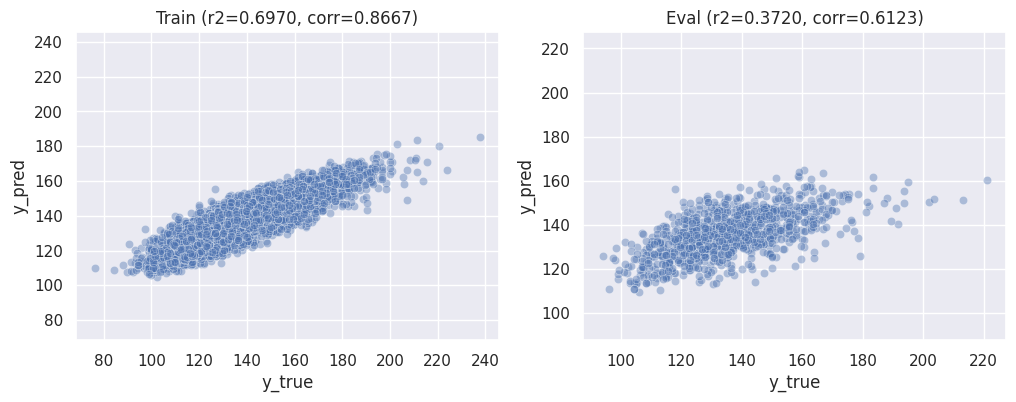

In [4]:
x_sbp, y_sbp = df_all.drop("SBP", "DBP"), df_all["SBP"]
sbp_sweep = wandb.Api().sweep("olink_sbp/t88bxe7n")
best_run = sbp_sweep.best_run(order="r2")
model_sbp = eval_xgb(x_sbp, y_sbp, best_run.config)

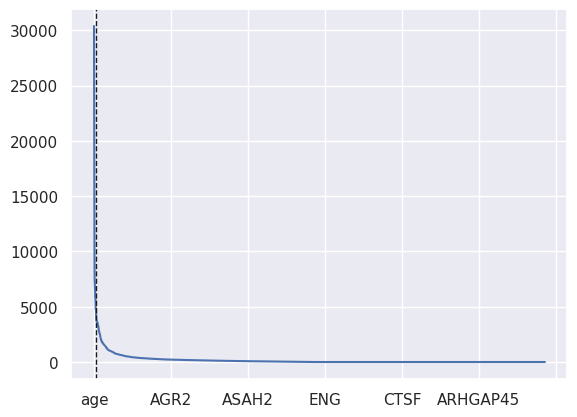

In [5]:
explainer = shap.TreeExplainer(model_sbp)
shap_values_sbp = explainer(x_sbp)
imps = shap_to_importance(shap_values_sbp, x_sbp.columns)
sbp_elbow = get_elbow_point(imps)
sbp_important_feats = imps[:sbp_elbow]

In [6]:
sbp_important_feats.index.values, f"Number of important feats: {len(sbp_important_feats)}"

(array(['age', 'REN', 'ACTA2', 'PTPRB', 'CHGB', 'CRIP2', 'PLAT', 'NADK',
        'HAVCR1', 'SPINK6', 'AGER', 'NCAN', 'SLC9A3R2', 'AMIGO2', 'CPM',
        'SIT1'], dtype=object),
 'Number of important feats: 16')

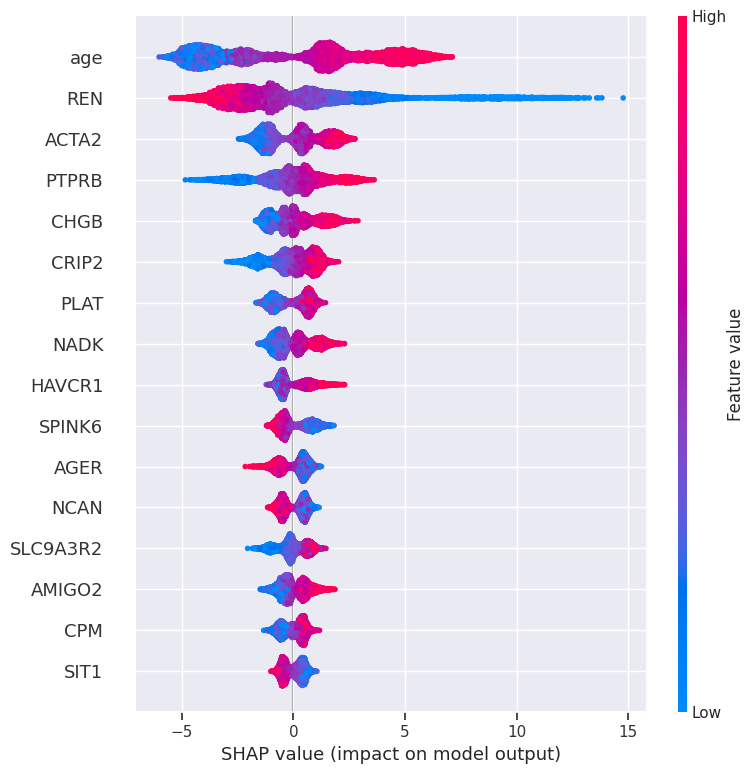

In [7]:
shap.summary_plot(shap_values_sbp, x_sbp.to_pandas(), max_display=min(len(sbp_important_feats), 20))

### DBP

wandb: Sorting runs by -summary_metrics.r2


[0]	validation_0-rmse:10.23641
[10]	validation_0-rmse:9.64498
[20]	validation_0-rmse:9.29492
[30]	validation_0-rmse:9.06840
[40]	validation_0-rmse:8.92442
[50]	validation_0-rmse:8.80273
[60]	validation_0-rmse:8.70719
[70]	validation_0-rmse:8.64135
[80]	validation_0-rmse:8.60664
[90]	validation_0-rmse:8.56810
[100]	validation_0-rmse:8.53453
[110]	validation_0-rmse:8.51516
[120]	validation_0-rmse:8.49347
[130]	validation_0-rmse:8.47629
[140]	validation_0-rmse:8.45816
[150]	validation_0-rmse:8.44092
[160]	validation_0-rmse:8.43693
[170]	validation_0-rmse:8.41666
[180]	validation_0-rmse:8.39417
[190]	validation_0-rmse:8.38817
[200]	validation_0-rmse:8.38271
[210]	validation_0-rmse:8.35930
[220]	validation_0-rmse:8.35764
[230]	validation_0-rmse:8.35409
[237]	validation_0-rmse:8.35326


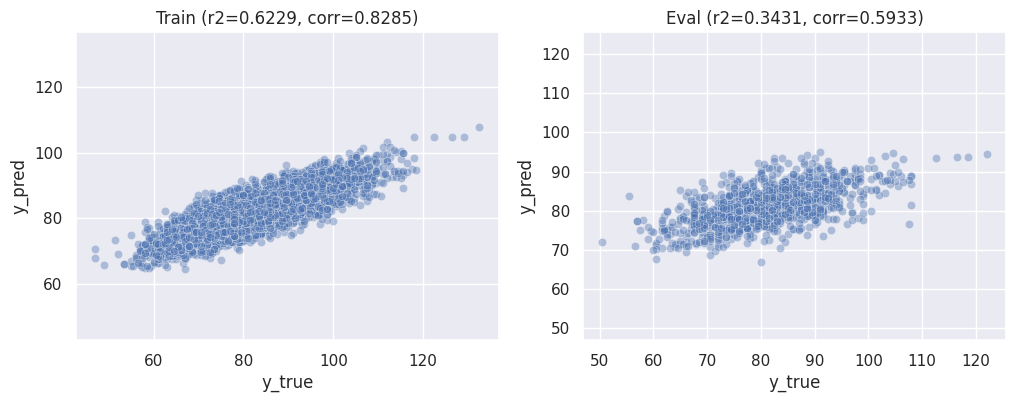

In [8]:
x_dbp, y_dbp = df_all.drop("SBP", "DBP"), df_all["DBP"]
dbp_sweep = wandb.Api().sweep("olink_dbp/2hndrq4o")
best_run = dbp_sweep.best_run(order="r2")
model_dbp = eval_xgb(x_dbp, y_dbp, best_run.config)

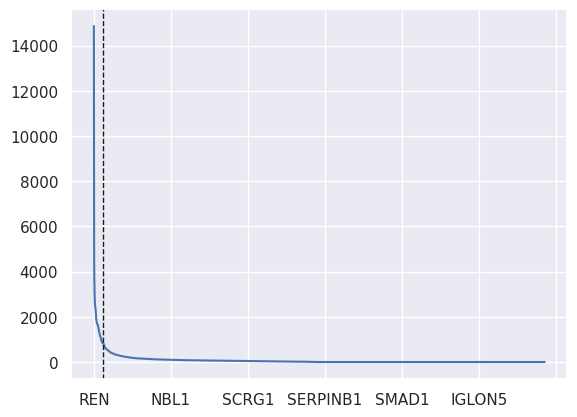

In [9]:
explainer = shap.TreeExplainer(model_dbp)
shap_values_dbp = explainer(x_dbp)
imps = shap_to_importance(shap_values_dbp, x_dbp.columns)
dbp_elbow = get_elbow_point(imps)
dbp_important_feats = imps[:dbp_elbow]

In [10]:
dbp_important_feats.index.values, f"Number of important feats: {len(dbp_important_feats)}"

(array(['REN', 'BMI', 'PTPRB', 'ACTA2', 'NTRK3', 'ANGPT2', 'PLAT', 'ACY1',
        'PLA2G10', 'CNTN3', 'ERBB2', 'CRIP2', 'APCS', 'JAM2', 'AGER',
        'NADK', 'LAYN', 'CHGB', 'AMIGO2', 'IL6', 'FCGR2B', 'RBP5', 'NPTXR',
        'IGFBP2', 'FABP1', 'GIP', 'TSHB', 'NTproBNP', 'COL4A1', 'CCER2',
        'SLC9A3R2', 'PYY', 'PIK3IP1', 'SIT1', 'C1QA', 'CPM', 'ACAN', 'sex',
        'SPINK6', 'IGSF9', 'ACE2', 'KLK3', 'CLEC4A', 'GCG', 'PSPN',
        'LMOD1', 'BCHE', 'TCTN3', 'SUSD5', 'PLA2G7', 'MXRA8', 'AOC3',
        'ICAM4', 'NOS3', 'VWC2', 'CXCL16', 'IL1R2'], dtype=object),
 'Number of important feats: 57')

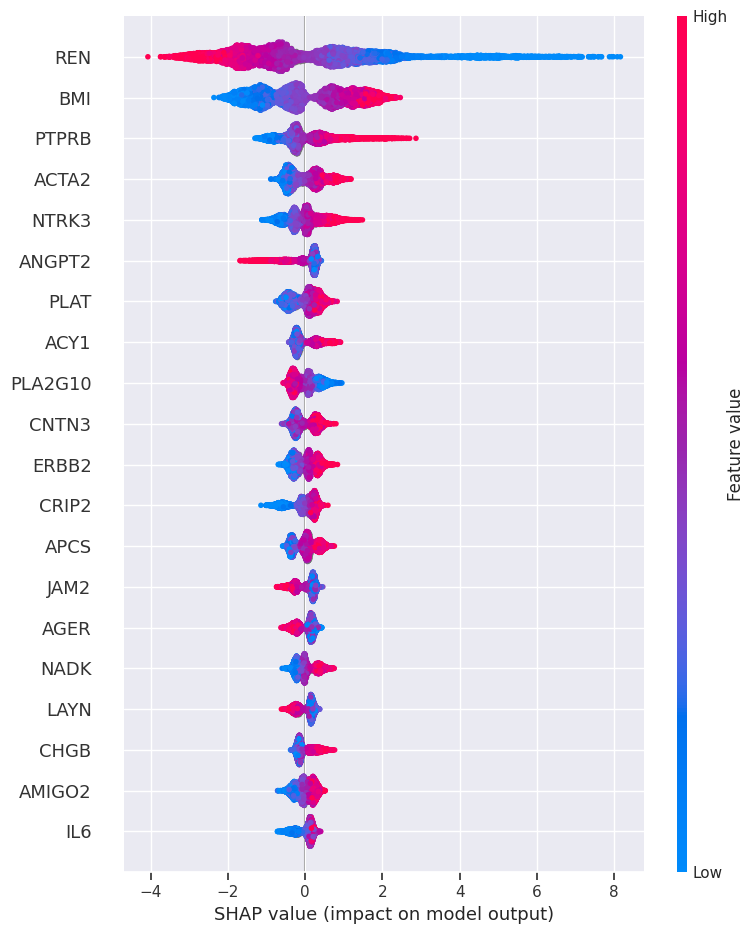

In [11]:
shap.summary_plot(shap_values_dbp, x_dbp.to_pandas(), max_display=min(len(dbp_important_feats), 20))

## Wandb sweep

In [13]:
def wandb_eval_xgb(config, x, y, seed=42):
    X_train, X_eval, y_train, y_eval = train_test_split(x, y, test_size=0.1, random_state=seed)

    estimator = setup_xgb(config, seed)
    estimator.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=0)
    return estimator.score(X_eval, y_eval)


target = "DBP"
project_name = f"olink_{target.lower()}"
x, y = df_all.drop("SBP", "DBP"), df_all[target]

objective = partial(wandb_eval_xgb, x=x, y=y)


def main():
    wandb.init(project=project_name)
    score = max(objective(wandb.config), -10)
    wandb.log({"r2": score})


sweep_configurations = {
    "method": "bayes",
    "metric": {"name": "r2", "goal": "maximize"},
    "parameters": {
        'n_estimators': {'distribution': 'int_uniform', 'min': 50, 'max': 500},
        'max_depth': {'distribution': 'int_uniform', 'min': 1, 'max': 10},
        'learning_rate': {'distribution': 'log_uniform_values', 'min': 0.001, 'max': 0.1},
        'subsample': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'colsample_bytree': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'gamma': {'distribution': 'uniform', 'min': 0, 'max': 10},
        'min_child_weight': {'distribution': 'int_uniform', 'min': 1, 'max': 20},
        'reg_alpha': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 100},
        'reg_lambda': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 100},
    },
}

sweep_id = wandb.sweep(sweep_configurations, project=project_name)
sweep_id

Create sweep with ID: 2hndrq4o
Sweep URL: https://wandb.ai/ipol/olink_dbp/sweeps/2hndrq4o


'2hndrq4o'

In [15]:
wandb.teardown()
wandb.agent(sweep_id, function=main)

wandb: Agent Starting Run: rztq0ftf with config:
wandb: 	colsample_bytree: 0.6153985746240966
wandb: 	gamma: 9.854697360727032
wandb: 	learning_rate: 0.014842135683458994
wandb: 	max_depth: 4
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 134
wandb: 	reg_alpha: 8.619932630009375
wandb: 	reg_lambda: 0.020179487450837433
wandb: 	subsample: 0.8331146509017406
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.23531


wandb: Agent Starting Run: wa4s4lec with config:
wandb: 	colsample_bytree: 0.7845232490296463
wandb: 	gamma: 3.0689205060601967
wandb: 	learning_rate: 0.01830144227821231
wandb: 	max_depth: 9
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 63
wandb: 	reg_alpha: 0.00013411593771080923
wandb: 	reg_lambda: 0.033963514238837395
wandb: 	subsample: 0.9855543626933584
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.21197


wandb: Agent Starting Run: e2g6wl8e with config:
wandb: 	colsample_bytree: 0.8196376465612506
wandb: 	gamma: 4.045308235541583
wandb: 	learning_rate: 0.012416180731614814
wandb: 	max_depth: 5
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 332
wandb: 	reg_alpha: 85.24566144348239
wandb: 	reg_lambda: 0.00015912764409941514
wandb: 	subsample: 0.912124739601518
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29273


wandb: Agent Starting Run: w1uxasu1 with config:
wandb: 	colsample_bytree: 0.6134866529664005
wandb: 	gamma: 9.69313600680658
wandb: 	learning_rate: 0.004540879800742702
wandb: 	max_depth: 9
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 76
wandb: 	reg_alpha: 2.4060468119592837
wandb: 	reg_lambda: 0.002723438310366721
wandb: 	subsample: 0.7378522496197446
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.09714


wandb: Agent Starting Run: xgr9shf3 with config:
wandb: 	colsample_bytree: 0.6767728648466023
wandb: 	gamma: 9.540255237236202
wandb: 	learning_rate: 0.007350995649683605
wandb: 	max_depth: 4
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 408
wandb: 	reg_alpha: 0.6777840830523819
wandb: 	reg_lambda: 0.00012927877786213555
wandb: 	subsample: 0.8271725434153743
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.26929


wandb: Agent Starting Run: sr32q0k0 with config:
wandb: 	colsample_bytree: 0.8123740710165802
wandb: 	gamma: 4.244291342413308
wandb: 	learning_rate: 0.00715118667628344
wandb: 	max_depth: 6
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 445
wandb: 	reg_alpha: 2.308399495091478
wandb: 	reg_lambda: 1.5495450022159274e-05
wandb: 	subsample: 0.8549478965217423
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.2875


wandb: Agent Starting Run: oq1zoq79 with config:
wandb: 	colsample_bytree: 0.9307605016124808
wandb: 	gamma: 4.1614814744433595
wandb: 	learning_rate: 0.0039695016303985765
wandb: 	max_depth: 2
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 451
wandb: 	reg_alpha: 4.869997247247559
wandb: 	reg_lambda: 9.515827802864365e-05
wandb: 	subsample: 0.9709690375984646
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.1705


wandb: Agent Starting Run: tgbqyama with config:
wandb: 	colsample_bytree: 0.8249296484871634
wandb: 	gamma: 3.861634752600843
wandb: 	learning_rate: 0.04020670915497035
wandb: 	max_depth: 9
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 372
wandb: 	reg_alpha: 0.3927311988965107
wandb: 	reg_lambda: 4.7972224401782035e-05
wandb: 	subsample: 0.8317983628304566
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.284


wandb: Agent Starting Run: cm5w2697 with config:
wandb: 	colsample_bytree: 0.8627585552200525
wandb: 	gamma: 6.614510293487919
wandb: 	learning_rate: 0.008903981678538569
wandb: 	max_depth: 7
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 327
wandb: 	reg_alpha: 28.100548011433805
wandb: 	reg_lambda: 0.00015997499120521815
wandb: 	subsample: 0.9580250644948972
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28104


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y7au8sek with config:
wandb: 	colsample_bytree: 0.7938840222808965
wandb: 	gamma: 3.262384121766515
wandb: 	learning_rate: 0.03680210380047269
wandb: 	max_depth: 7
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 416
wandb: 	reg_alpha: 0.19711165398270425
wandb: 	reg_lambda: 0.0002938486258025351
wandb: 	subsample: 0.8671046276062064
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31836


wandb: Agent Starting Run: hzyb5lda with config:
wandb: 	colsample_bytree: 0.6608324610396059
wandb: 	gamma: 2.414334481071326
wandb: 	learning_rate: 0.0552168918124663
wandb: 	max_depth: 5
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 350
wandb: 	reg_alpha: 43.8406444993533
wandb: 	reg_lambda: 2.2333538638086703e-05
wandb: 	subsample: 0.9552977897336552
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31986


wandb: Agent Starting Run: 52lz4giy with config:
wandb: 	colsample_bytree: 0.6812609043878564
wandb: 	gamma: 1.4326972162636509
wandb: 	learning_rate: 0.03325915527950735
wandb: 	max_depth: 7
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 446
wandb: 	reg_alpha: 39.43141202954399
wandb: 	reg_lambda: 5.294804886377557e-05
wandb: 	subsample: 0.6356273780848603
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32077


wandb: Agent Starting Run: cyn2jft0 with config:
wandb: 	colsample_bytree: 0.6780163388277687
wandb: 	gamma: 0.359407674930875
wandb: 	learning_rate: 0.04136473172193712
wandb: 	max_depth: 6
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 442
wandb: 	reg_alpha: 34.44651168695035
wandb: 	reg_lambda: 0.030022253965862843
wandb: 	subsample: 0.8127320889324072
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32545


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bttx0nge with config:
wandb: 	colsample_bytree: 0.8119769671058078
wandb: 	gamma: 0.003853498379571274
wandb: 	learning_rate: 0.024033316681967672
wandb: 	max_depth: 9
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 350
wandb: 	reg_alpha: 21.226435441948027
wandb: 	reg_lambda: 3.661068785893191e-05
wandb: 	subsample: 0.814029581724889
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.294


wandb: Agent Starting Run: z1sld8g3 with config:
wandb: 	colsample_bytree: 0.5122663001498977
wandb: 	gamma: 0.8614810885219348
wandb: 	learning_rate: 0.0824143603493844
wandb: 	max_depth: 5
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 471
wandb: 	reg_alpha: 81.60852432237098
wandb: 	reg_lambda: 1.9615794197108487
wandb: 	subsample: 0.6527923036509317
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30685


wandb: Agent Starting Run: 3j7l5qwq with config:
wandb: 	colsample_bytree: 0.5651742228541028
wandb: 	gamma: 1.875633530706504
wandb: 	learning_rate: 0.06904641608065804
wandb: 	max_depth: 9
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 464
wandb: 	reg_alpha: 26.452173171075493
wandb: 	reg_lambda: 8.82603982797144e-05
wandb: 	subsample: 0.9101772241244755
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.27332


wandb: Agent Starting Run: 80e1t85t with config:
wandb: 	colsample_bytree: 0.6363231287371922
wandb: 	gamma: 1.147759323841986
wandb: 	learning_rate: 0.02092526593218488
wandb: 	max_depth: 5
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 410
wandb: 	reg_alpha: 84.03284254992293
wandb: 	reg_lambda: 0.0035509711242016255
wandb: 	subsample: 0.8840259199068894
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32202


wandb: Agent Starting Run: yxl960v2 with config:
wandb: 	colsample_bytree: 0.6240803773181737
wandb: 	gamma: 3.241582250146905
wandb: 	learning_rate: 0.06239936147899842
wandb: 	max_depth: 5
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 481
wandb: 	reg_alpha: 2.4180238760429686
wandb: 	reg_lambda: 1.0310543958507508e-05
wandb: 	subsample: 0.7128577066810684
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32409


wandb: Agent Starting Run: mk10mbs5 with config:
wandb: 	colsample_bytree: 0.6427594508749034
wandb: 	gamma: 1.6343207607820365
wandb: 	learning_rate: 0.02169831967097386
wandb: 	max_depth: 7
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 468
wandb: 	reg_alpha: 9.558801479910516
wandb: 	reg_lambda: 0.0004540006212732716
wandb: 	subsample: 0.9062281637320776
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30442


wandb: Agent Starting Run: j7jz7ggd with config:
wandb: 	colsample_bytree: 0.739589486341691
wandb: 	gamma: 0.7442655518665764
wandb: 	learning_rate: 0.0568457904704343
wandb: 	max_depth: 4
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 493
wandb: 	reg_alpha: 28.196127180442517
wandb: 	reg_lambda: 0.0033825474373434337
wandb: 	subsample: 0.6712346582102635
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29771


wandb: Agent Starting Run: g7hda8bc with config:
wandb: 	colsample_bytree: 0.5163473452649844
wandb: 	gamma: 2.4142239613887053
wandb: 	learning_rate: 0.08270303037048056
wandb: 	max_depth: 2
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 416
wandb: 	reg_alpha: 0.10914056676637612
wandb: 	reg_lambda: 0.04836200681241405
wandb: 	subsample: 0.764094240935755
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3324


wandb: Agent Starting Run: gh4g7g29 with config:
wandb: 	colsample_bytree: 0.5067256240459918
wandb: 	gamma: 1.656508011591964
wandb: 	learning_rate: 0.07733306388173547
wandb: 	max_depth: 6
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 471
wandb: 	reg_alpha: 0.0509023830687692
wandb: 	reg_lambda: 0.000246932403463165
wandb: 	subsample: 0.8277840053484817
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3159


wandb: Agent Starting Run: behigf6a with config:
wandb: 	colsample_bytree: 0.5246123412911359
wandb: 	gamma: 1.3268604479994572
wandb: 	learning_rate: 0.09981719591582663
wandb: 	max_depth: 2
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 394
wandb: 	reg_alpha: 0.5080567201156194
wandb: 	reg_lambda: 1.0012209706378266
wandb: 	subsample: 0.892572656422747
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31628


wandb: Agent Starting Run: i9hfqlyi with config:
wandb: 	colsample_bytree: 0.605521723436881
wandb: 	gamma: 2.090882251037659
wandb: 	learning_rate: 0.0902850813026784
wandb: 	max_depth: 8
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 434
wandb: 	reg_alpha: 9.664690497949216
wandb: 	reg_lambda: 0.24269600300886887
wandb: 	subsample: 0.994757460193234
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.26085


wandb: Agent Starting Run: 2sae0mqt with config:
wandb: 	colsample_bytree: 0.6014743584656765
wandb: 	gamma: 1.4968481118066268
wandb: 	learning_rate: 0.04633477859062312
wandb: 	max_depth: 1
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 443
wandb: 	reg_alpha: 3.223320387341603e-05
wandb: 	reg_lambda: 0.2381871982136245
wandb: 	subsample: 0.6723494105666816
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29599


wandb: Agent Starting Run: 588lqc1s with config:
wandb: 	colsample_bytree: 0.6065334572581279
wandb: 	gamma: 0.6900495791893946
wandb: 	learning_rate: 0.09774646820269192
wandb: 	max_depth: 3
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 454
wandb: 	reg_alpha: 0.05160784974628777
wandb: 	reg_lambda: 9.634752872522323e-05
wandb: 	subsample: 0.5519003920024579
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.33677


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5nmz6kx7 with config:
wandb: 	colsample_bytree: 0.5855520999637331
wandb: 	gamma: 0.4587115307284828
wandb: 	learning_rate: 0.025267077584150133
wandb: 	max_depth: 4
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 453
wandb: 	reg_alpha: 11.23869038263927
wandb: 	reg_lambda: 9.58917173067494e-05
wandb: 	subsample: 0.6215451404407698
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32671


wandb: Agent Starting Run: 8fd7yyc8 with config:
wandb: 	colsample_bytree: 0.5607715527546823
wandb: 	gamma: 1.4015986833936434
wandb: 	learning_rate: 0.04040816058993306
wandb: 	max_depth: 2
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 338
wandb: 	reg_alpha: 0.0007773078557118261
wandb: 	reg_lambda: 4.820127950002496e-05
wandb: 	subsample: 0.8347104132525489
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30977


wandb: Agent Starting Run: 71s5mjj5 with config:
wandb: 	colsample_bytree: 0.6714893232915788
wandb: 	gamma: 0.6142847612496316
wandb: 	learning_rate: 0.09600565168931569
wandb: 	max_depth: 5
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 383
wandb: 	reg_alpha: 2.4081109641828156
wandb: 	reg_lambda: 7.232531084597501e-05
wandb: 	subsample: 0.7928686125896142
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29574


wandb: Agent Starting Run: yr8x7noe with config:
wandb: 	colsample_bytree: 0.6881492397902316
wandb: 	gamma: 4.1833606551133675
wandb: 	learning_rate: 0.08208995612600137
wandb: 	max_depth: 4
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 433
wandb: 	reg_alpha: 0.0004484587017914083
wandb: 	reg_lambda: 0.00013985158625701705
wandb: 	subsample: 0.5063352132195231
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30993


wandb: Agent Starting Run: n6a6cpjc with config:
wandb: 	colsample_bytree: 0.5035594573673436
wandb: 	gamma: 0.4357544415590075
wandb: 	learning_rate: 0.04274923792109418
wandb: 	max_depth: 4
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 343
wandb: 	reg_alpha: 0.001208673804954686
wandb: 	reg_lambda: 0.0002608842453072468
wandb: 	subsample: 0.5192658967258785
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31952


wandb: Agent Starting Run: zsa3dum2 with config:
wandb: 	colsample_bytree: 0.5744676160423232
wandb: 	gamma: 1.3455930067141009
wandb: 	learning_rate: 0.02385541207520782
wandb: 	max_depth: 3
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 425
wandb: 	reg_alpha: 0.5405119474324659
wandb: 	reg_lambda: 1.5407539048726507e-05
wandb: 	subsample: 0.7372702508361162
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31824


wandb: Agent Starting Run: w8180czh with config:
wandb: 	colsample_bytree: 0.5084585575833152
wandb: 	gamma: 2.465497666579627
wandb: 	learning_rate: 0.0681254353545846
wandb: 	max_depth: 1
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 399
wandb: 	reg_alpha: 0.19194957898922252
wandb: 	reg_lambda: 0.0008553262363015942
wandb: 	subsample: 0.625745224368023
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30516


wandb: Agent Starting Run: wgqfyf06 with config:
wandb: 	colsample_bytree: 0.6068562704469109
wandb: 	gamma: 3.189508337326555
wandb: 	learning_rate: 0.014594622633744314
wandb: 	max_depth: 6
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 481
wandb: 	reg_alpha: 0.23368917340768008
wandb: 	reg_lambda: 0.04471063265424104
wandb: 	subsample: 0.6096334270351924
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31923


wandb: Agent Starting Run: tl2fj4av with config:
wandb: 	colsample_bytree: 0.5356040249278575
wandb: 	gamma: 1.2103486389935836
wandb: 	learning_rate: 0.010901982825997853
wandb: 	max_depth: 3
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 467
wandb: 	reg_alpha: 0.000996472012686325
wandb: 	reg_lambda: 0.0005321890593109774
wandb: 	subsample: 0.5348082917648809
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28779


wandb: Agent Starting Run: l679xeu4 with config:
wandb: 	colsample_bytree: 0.5100019765267692
wandb: 	gamma: 0.35925699277169043
wandb: 	learning_rate: 0.021095971962967745
wandb: 	max_depth: 4
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 413
wandb: 	reg_alpha: 3.6065023570772343
wandb: 	reg_lambda: 0.17777016182674846
wandb: 	subsample: 0.737590532770042
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32376


wandb: Agent Starting Run: dhtem8zf with config:
wandb: 	colsample_bytree: 0.5474064646635006
wandb: 	gamma: 0.8665954407941368
wandb: 	learning_rate: 0.08690288803473391
wandb: 	max_depth: 1
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 294
wandb: 	reg_alpha: 0.10137145865921732
wandb: 	reg_lambda: 1.141616086163473
wandb: 	subsample: 0.5878676439823325
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3048


wandb: Agent Starting Run: jsiz1rhb with config:
wandb: 	colsample_bytree: 0.5404723374577135
wandb: 	gamma: 3.2487030379302873
wandb: 	learning_rate: 0.0529263577718811
wandb: 	max_depth: 3
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 495
wandb: 	reg_alpha: 3.2177236600154493
wandb: 	reg_lambda: 0.00043171582559454975
wandb: 	subsample: 0.8657238370680744
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32253


wandb: Agent Starting Run: g6ah1wbh with config:
wandb: 	colsample_bytree: 0.554551282831101
wandb: 	gamma: 0.8597597875251106
wandb: 	learning_rate: 0.0278105678205781
wandb: 	max_depth: 6
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 499
wandb: 	reg_alpha: 0.059323577093102015
wandb: 	reg_lambda: 8.928631976969975e-05
wandb: 	subsample: 0.5701662678584842
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3105


wandb: Agent Starting Run: u8ncymlh with config:
wandb: 	colsample_bytree: 0.5004228959211711
wandb: 	gamma: 0.6185700842759467
wandb: 	learning_rate: 0.06347162132181486
wandb: 	max_depth: 2
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 480
wandb: 	reg_alpha: 0.7703429376554545
wandb: 	reg_lambda: 0.013743994386391487
wandb: 	subsample: 0.6553376874654517
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32021


wandb: Agent Starting Run: 3vz12lch with config:
wandb: 	colsample_bytree: 0.5112679346463461
wandb: 	gamma: 6.739254993260467
wandb: 	learning_rate: 0.05147815867173234
wandb: 	max_depth: 2
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 477
wandb: 	reg_alpha: 0.8296479379581333
wandb: 	reg_lambda: 0.005647486536256793
wandb: 	subsample: 0.8059392787358128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32338


wandb: Agent Starting Run: hyq9nx5f with config:
wandb: 	colsample_bytree: 0.5220546160378021
wandb: 	gamma: 1.3071537656633092
wandb: 	learning_rate: 0.06990265359062495
wandb: 	max_depth: 2
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 392
wandb: 	reg_alpha: 1.753428154763111e-05
wandb: 	reg_lambda: 8.262415348289499e-05
wandb: 	subsample: 0.560817476241247
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3187


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2n2zb6rq with config:
wandb: 	colsample_bytree: 0.5497961345782081
wandb: 	gamma: 0.7833717814662167
wandb: 	learning_rate: 0.09467058576951844
wandb: 	max_depth: 1
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 442
wandb: 	reg_alpha: 0.024047978238405616
wandb: 	reg_lambda: 1.1275695091620423
wandb: 	subsample: 0.6363712781051118
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29551


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n97wltu8 with config:
wandb: 	colsample_bytree: 0.5638775862785042
wandb: 	gamma: 4.387067242142493
wandb: 	learning_rate: 0.041819520470095586
wandb: 	max_depth: 6
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 462
wandb: 	reg_alpha: 4.613520752332578
wandb: 	reg_lambda: 0.04315388425015461
wandb: 	subsample: 0.7421978488143395
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30818


wandb: Agent Starting Run: q3ipyztm with config:
wandb: 	colsample_bytree: 0.6467318624931094
wandb: 	gamma: 2.2261371396244956
wandb: 	learning_rate: 0.09220721665679638
wandb: 	max_depth: 1
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 251
wandb: 	reg_alpha: 56.45418566655125
wandb: 	reg_lambda: 0.00014473901959289478
wandb: 	subsample: 0.526871471326035
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30117


wandb: Agent Starting Run: ev48m3cn with config:
wandb: 	colsample_bytree: 0.5138022006275895
wandb: 	gamma: 1.2395082193798523
wandb: 	learning_rate: 0.05091688955815229
wandb: 	max_depth: 1
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 334
wandb: 	reg_alpha: 0.28835248887172676
wandb: 	reg_lambda: 2.9940162158957673e-05
wandb: 	subsample: 0.6200784701377855
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28727


wandb: Agent Starting Run: o2g7qfx4 with config:
wandb: 	colsample_bytree: 0.5052388127282843
wandb: 	gamma: 5.357268541095307
wandb: 	learning_rate: 0.041958233761208504
wandb: 	max_depth: 2
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 496
wandb: 	reg_alpha: 3.7853938365708695e-05
wandb: 	reg_lambda: 0.00041048125390289256
wandb: 	subsample: 0.8877341137471901
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32099


wandb: Agent Starting Run: 8pgk1mam with config:
wandb: 	colsample_bytree: 0.6223275069401162
wandb: 	gamma: 2.507883204883644
wandb: 	learning_rate: 0.07766565065726853
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 469
wandb: 	reg_alpha: 0.1419498363490262
wandb: 	reg_lambda: 0.007450544933103415
wandb: 	subsample: 0.9425955381599128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31801


wandb: Agent Starting Run: 08nqybhr with config:
wandb: 	colsample_bytree: 0.5375930141408218
wandb: 	gamma: 2.586586980953265
wandb: 	learning_rate: 0.09990089611351646
wandb: 	max_depth: 3
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 407
wandb: 	reg_alpha: 0.01300983697754798
wandb: 	reg_lambda: 0.002485580327232184
wandb: 	subsample: 0.7260131167761162
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31245


wandb: Agent Starting Run: nyu7mr1o with config:
wandb: 	colsample_bytree: 0.5490792417355997
wandb: 	gamma: 2.2172318395441035
wandb: 	learning_rate: 0.008372990656442758
wandb: 	max_depth: 5
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 488
wandb: 	reg_alpha: 23.61144871216802
wandb: 	reg_lambda: 2.2333014915132163e-05
wandb: 	subsample: 0.6267164211620744
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29751


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q1xwlgg4 with config:
wandb: 	colsample_bytree: 0.5489440651115073
wandb: 	gamma: 5.287620966585832
wandb: 	learning_rate: 0.09914928939835088
wandb: 	max_depth: 2
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 490
wandb: 	reg_alpha: 0.06949614805038265
wandb: 	reg_lambda: 0.2098081821090827
wandb: 	subsample: 0.8406488892114299
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32066


wandb: Agent Starting Run: 3qrwze2t with config:
wandb: 	colsample_bytree: 0.5200201389746766
wandb: 	gamma: 2.780165852031915
wandb: 	learning_rate: 0.0351820314302624
wandb: 	max_depth: 1
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 458
wandb: 	reg_alpha: 0.021756969738554705
wandb: 	reg_lambda: 8.577418336505272e-05
wandb: 	subsample: 0.8763876092927438
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.2798


wandb: Agent Starting Run: 8nez3cze with config:
wandb: 	colsample_bytree: 0.6204772002681247
wandb: 	gamma: 3.2633008811867583
wandb: 	learning_rate: 0.03757641472757189
wandb: 	max_depth: 6
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 496
wandb: 	reg_alpha: 1.0183387498103426e-05
wandb: 	reg_lambda: 0.00034076452016499394
wandb: 	subsample: 0.8392359155906772
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3151


wandb: Agent Starting Run: 79ri4oww with config:
wandb: 	colsample_bytree: 0.5387524117143359
wandb: 	gamma: 1.221859066669605
wandb: 	learning_rate: 0.0963573219599691
wandb: 	max_depth: 4
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 354
wandb: 	reg_alpha: 9.852670149503505e-05
wandb: 	reg_lambda: 1.9298003698305057e-05
wandb: 	subsample: 0.5578269500521014
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.303


wandb: Agent Starting Run: 37bofhn5 with config:
wandb: 	colsample_bytree: 0.5535978602384564
wandb: 	gamma: 8.085625349295908
wandb: 	learning_rate: 0.09175905289292866
wandb: 	max_depth: 4
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 492
wandb: 	reg_alpha: 9.018241615733269e-05
wandb: 	reg_lambda: 0.011158270796476265
wandb: 	subsample: 0.9850046598326196
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3347


wandb: Agent Starting Run: dijw3td8 with config:
wandb: 	colsample_bytree: 0.5146946596289506
wandb: 	gamma: 8.000113240528941
wandb: 	learning_rate: 0.0754143977001872
wandb: 	max_depth: 3
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 492
wandb: 	reg_alpha: 0.003412875962059432
wandb: 	reg_lambda: 1.4133476793823116e-05
wandb: 	subsample: 0.8032201410014947
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31593


wandb: Agent Starting Run: qrb90nse with config:
wandb: 	colsample_bytree: 0.502280815577097
wandb: 	gamma: 0.11742325148838106
wandb: 	learning_rate: 0.013914106292184624
wandb: 	max_depth: 3
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 367
wandb: 	reg_alpha: 50.01536135121745
wandb: 	reg_lambda: 0.15592492558580268
wandb: 	subsample: 0.5081322455003312
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.2866


wandb: Agent Starting Run: 72kafsp3 with config:
wandb: 	colsample_bytree: 0.5229995207228628
wandb: 	gamma: 2.9801643050804727
wandb: 	learning_rate: 0.0954822556277778
wandb: 	max_depth: 4
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 495
wandb: 	reg_alpha: 0.0005810336051130342
wandb: 	reg_lambda: 0.03347131108414307
wandb: 	subsample: 0.6077703187996077
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3071


wandb: Agent Starting Run: cajeja41 with config:
wandb: 	colsample_bytree: 0.687656474954269
wandb: 	gamma: 6.945530164572303
wandb: 	learning_rate: 0.06310874056514242
wandb: 	max_depth: 5
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 469
wandb: 	reg_alpha: 0.00010343423826517312
wandb: 	reg_lambda: 0.00031427650291226044
wandb: 	subsample: 0.6875901519085292
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29121


wandb: Agent Starting Run: epaw2n1o with config:
wandb: 	colsample_bytree: 0.5611893577730316
wandb: 	gamma: 9.750621356540352
wandb: 	learning_rate: 0.0354444359608811
wandb: 	max_depth: 3
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 488
wandb: 	reg_alpha: 9.028810895668044e-05
wandb: 	reg_lambda: 0.0004145056128030337
wandb: 	subsample: 0.9594748011700788
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32101


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0qp7bdpi with config:
wandb: 	colsample_bytree: 0.5039810992693112
wandb: 	gamma: 6.70268762396172
wandb: 	learning_rate: 0.06105707202650899
wandb: 	max_depth: 1
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 382
wandb: 	reg_alpha: 0.0002374516261538537
wandb: 	reg_lambda: 16.31549695959083
wandb: 	subsample: 0.875783914529686
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29582


wandb: Agent Starting Run: 214dgyyb with config:
wandb: 	colsample_bytree: 0.5743045045978978
wandb: 	gamma: 0.05884308397746008
wandb: 	learning_rate: 0.09344410883962909
wandb: 	max_depth: 5
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 443
wandb: 	reg_alpha: 2.891055545618476e-05
wandb: 	reg_lambda: 0.05926444746364458
wandb: 	subsample: 0.8826238332776384
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31298


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p2hx958f with config:
wandb: 	colsample_bytree: 0.717105570717809
wandb: 	gamma: 2.4341495797689205
wandb: 	learning_rate: 0.09285249647820762
wandb: 	max_depth: 8
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 483
wandb: 	reg_alpha: 17.07036725501621
wandb: 	reg_lambda: 0.0001002835492930002
wandb: 	subsample: 0.5123668549745997
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.27192


wandb: Agent Starting Run: dekytl25 with config:
wandb: 	colsample_bytree: 0.5376025986538928
wandb: 	gamma: 2.387705117973866
wandb: 	learning_rate: 0.046540925164652365
wandb: 	max_depth: 3
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 458
wandb: 	reg_alpha: 0.2854324843571074
wandb: 	reg_lambda: 0.0014036554106934044
wandb: 	subsample: 0.8145759639473777
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32243


wandb: Agent Starting Run: ru8c0d49 with config:
wandb: 	colsample_bytree: 0.6973073144547057
wandb: 	gamma: 2.707785643800904
wandb: 	learning_rate: 0.09232091040976129
wandb: 	max_depth: 4
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 472
wandb: 	reg_alpha: 3.1887459392707385
wandb: 	reg_lambda: 2.4205563345803155e-05
wandb: 	subsample: 0.5516569271358038
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31079


wandb: Agent Starting Run: errp4oag with config:
wandb: 	colsample_bytree: 0.5868144486050745
wandb: 	gamma: 5.821365381981826
wandb: 	learning_rate: 0.06807372380996692
wandb: 	max_depth: 7
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 488
wandb: 	reg_alpha: 2.413470118343681e-05
wandb: 	reg_lambda: 0.06891604799636102
wandb: 	subsample: 0.8377215841092298
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29389


wandb: Agent Starting Run: ho62hyqi with config:
wandb: 	colsample_bytree: 0.6416761731524436
wandb: 	gamma: 3.101456176632925
wandb: 	learning_rate: 0.015627142769834144
wandb: 	max_depth: 6
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 462
wandb: 	reg_alpha: 12.592577830615532
wandb: 	reg_lambda: 0.0012238219102702638
wandb: 	subsample: 0.7114946761822271
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31611


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 757ffl1n with config:
wandb: 	colsample_bytree: 0.5097095219707343
wandb: 	gamma: 9.232725528625704
wandb: 	learning_rate: 0.05764182549336854
wandb: 	max_depth: 6
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 481
wandb: 	reg_alpha: 0.3909026472285897
wandb: 	reg_lambda: 5.865821360228727e-05
wandb: 	subsample: 0.9864955738106174
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31125


wandb: Agent Starting Run: zrqmaoy7 with config:
wandb: 	colsample_bytree: 0.6004921627280182
wandb: 	gamma: 8.29899771025877
wandb: 	learning_rate: 0.09828404687158156
wandb: 	max_depth: 1
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 468
wandb: 	reg_alpha: 6.636471764885074e-05
wandb: 	reg_lambda: 1.6909706630777875e-05
wandb: 	subsample: 0.9737568660809722
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31149


wandb: Agent Starting Run: obqlzxr0 with config:
wandb: 	colsample_bytree: 0.7633032764527296
wandb: 	gamma: 8.538844618881559
wandb: 	learning_rate: 0.06962739461743778
wandb: 	max_depth: 6
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 485
wandb: 	reg_alpha: 6.500003746849561e-05
wandb: 	reg_lambda: 0.00023990826435368927
wandb: 	subsample: 0.9761371762348396
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31409


wandb: Agent Starting Run: i87l8uqb with config:
wandb: 	colsample_bytree: 0.5290131882119038
wandb: 	gamma: 7.28230719895821
wandb: 	learning_rate: 0.06536491682104127
wandb: 	max_depth: 4
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 452
wandb: 	reg_alpha: 0.00012465704997501962
wandb: 	reg_lambda: 0.0001541454213047767
wandb: 	subsample: 0.9258648833947594
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30063


wandb: Agent Starting Run: 3z6pztsa with config:
wandb: 	colsample_bytree: 0.6583128349966914
wandb: 	gamma: 6.177569998300411
wandb: 	learning_rate: 0.08584636274304479
wandb: 	max_depth: 1
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 411
wandb: 	reg_alpha: 14.51562412706103
wandb: 	reg_lambda: 0.01601172185902919
wandb: 	subsample: 0.9922931744165312
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29843


wandb: Agent Starting Run: n93dbzjh with config:
wandb: 	colsample_bytree: 0.6131372468288976
wandb: 	gamma: 4.598955833100228
wandb: 	learning_rate: 0.09409889208098232
wandb: 	max_depth: 2
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 458
wandb: 	reg_alpha: 5.040099789032787e-05
wandb: 	reg_lambda: 31.643990542045675
wandb: 	subsample: 0.97491521013282
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32061


wandb: Agent Starting Run: ncdl8o11 with config:
wandb: 	colsample_bytree: 0.5544204354102202
wandb: 	gamma: 5.78786256109523
wandb: 	learning_rate: 0.05908387533107199
wandb: 	max_depth: 3
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 484
wandb: 	reg_alpha: 77.12565711991694
wandb: 	reg_lambda: 8.789448324120807e-05
wandb: 	subsample: 0.7641525092349353
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32944


wandb: Agent Starting Run: 77fdrojx with config:
wandb: 	colsample_bytree: 0.5562674447559262
wandb: 	gamma: 6.092631412587155
wandb: 	learning_rate: 0.09889026604585922
wandb: 	max_depth: 2
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 484
wandb: 	reg_alpha: 42.11674772958279
wandb: 	reg_lambda: 0.010042811932712132
wandb: 	subsample: 0.8052032025047048
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.33407


wandb: Agent Starting Run: 3nlea5wa with config:
wandb: 	colsample_bytree: 0.5100075204366474
wandb: 	gamma: 2.9380679864827117
wandb: 	learning_rate: 0.014766881178392269
wandb: 	max_depth: 2
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 499
wandb: 	reg_alpha: 48.11270402455177
wandb: 	reg_lambda: 24.423332848894574
wandb: 	subsample: 0.737253299238242
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28009


wandb: Agent Starting Run: gu1qyclv with config:
wandb: 	colsample_bytree: 0.6647470588898379
wandb: 	gamma: 0.4214791702333587
wandb: 	learning_rate: 0.026295990437502647
wandb: 	max_depth: 5
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 475
wandb: 	reg_alpha: 0.003689009551072856
wandb: 	reg_lambda: 0.000968885134210197
wandb: 	subsample: 0.8069370028986331
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30575


wandb: Agent Starting Run: uqka2kxq with config:
wandb: 	colsample_bytree: 0.6627038511544291
wandb: 	gamma: 8.705002526716271
wandb: 	learning_rate: 0.08301315690626136
wandb: 	max_depth: 5
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 480
wandb: 	reg_alpha: 0.9270306467459548
wandb: 	reg_lambda: 0.00017753096381673065
wandb: 	subsample: 0.9571870294506712
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32133


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fn5y4biz with config:
wandb: 	colsample_bytree: 0.5627885719837715
wandb: 	gamma: 9.842861696198757
wandb: 	learning_rate: 0.05399125189801305
wandb: 	max_depth: 2
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 491
wandb: 	reg_alpha: 5.907297612504674
wandb: 	reg_lambda: 0.0029259748448432496
wandb: 	subsample: 0.8016252919528489
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32325


wandb: Agent Starting Run: 2et8rtjc with config:
wandb: 	colsample_bytree: 0.5220709612886376
wandb: 	gamma: 9.359615252385256
wandb: 	learning_rate: 0.06864458440224194
wandb: 	max_depth: 3
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 447
wandb: 	reg_alpha: 13.91898749648631
wandb: 	reg_lambda: 0.00011235941987368816
wandb: 	subsample: 0.7378726265436899
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31855


wandb: Agent Starting Run: ttcskh9m with config:
wandb: 	colsample_bytree: 0.6688120925418617
wandb: 	gamma: 7.616314039653953
wandb: 	learning_rate: 0.04796981843424718
wandb: 	max_depth: 2
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 389
wandb: 	reg_alpha: 0.00011420537038916146
wandb: 	reg_lambda: 0.3253893587922291
wandb: 	subsample: 0.975681873938362
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31664


wandb: Agent Starting Run: qnzm7y08 with config:
wandb: 	colsample_bytree: 0.6343822049875458
wandb: 	gamma: 1.020783054897999
wandb: 	learning_rate: 0.09853583331466996
wandb: 	max_depth: 1
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 317
wandb: 	reg_alpha: 5.104706255046797e-05
wandb: 	reg_lambda: 0.007184742658826537
wandb: 	subsample: 0.9606433333486122
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30585


wandb: Agent Starting Run: 50vpyjwa with config:
wandb: 	colsample_bytree: 0.5260963219703346
wandb: 	gamma: 0.725180903424476
wandb: 	learning_rate: 0.059930661529777114
wandb: 	max_depth: 5
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 377
wandb: 	reg_alpha: 1.0344540617809117
wandb: 	reg_lambda: 0.04489273070988269
wandb: 	subsample: 0.7524945680951078
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30791


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3un9vf22 with config:
wandb: 	colsample_bytree: 0.5826094871907295
wandb: 	gamma: 9.143307489802089
wandb: 	learning_rate: 0.050842875229408606
wandb: 	max_depth: 3
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 456
wandb: 	reg_alpha: 0.0011740295206513914
wandb: 	reg_lambda: 0.013446459547841485
wandb: 	subsample: 0.998156449659216
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32703


wandb: Agent Starting Run: ofy9k5kv with config:
wandb: 	colsample_bytree: 0.5134876886457789
wandb: 	gamma: 9.409341830147572
wandb: 	learning_rate: 0.05130242174309317
wandb: 	max_depth: 2
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 451
wandb: 	reg_alpha: 1.0758346917476487e-05
wandb: 	reg_lambda: 0.007044221631847294
wandb: 	subsample: 0.9569785343465036
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31566


wandb: Agent Starting Run: qb6tc05c with config:
wandb: 	colsample_bytree: 0.547548475303085
wandb: 	gamma: 9.31982358323127
wandb: 	learning_rate: 0.09397473380746772
wandb: 	max_depth: 1
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 483
wandb: 	reg_alpha: 7.442173440525292e-05
wandb: 	reg_lambda: 0.05030146330651585
wandb: 	subsample: 0.7666154585381859
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30821


wandb: Agent Starting Run: ukejqqqk with config:
wandb: 	colsample_bytree: 0.7732636382143687
wandb: 	gamma: 4.293937664095749
wandb: 	learning_rate: 0.06230446307610596
wandb: 	max_depth: 5
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 496
wandb: 	reg_alpha: 0.6517146136822293
wandb: 	reg_lambda: 2.8955323031205344e-05
wandb: 	subsample: 0.8213429135081725
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29769


wandb: Agent Starting Run: dplmux7q with config:
wandb: 	colsample_bytree: 0.6515415755824578
wandb: 	gamma: 9.791534158866073
wandb: 	learning_rate: 0.032349977193393664
wandb: 	max_depth: 2
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 464
wandb: 	reg_alpha: 0.0023008901954512904
wandb: 	reg_lambda: 7.610225438520335
wandb: 	subsample: 0.9983897410373102
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30991


wandb: Agent Starting Run: nf11w5to with config:
wandb: 	colsample_bytree: 0.7032966148169384
wandb: 	gamma: 0.10221485097781312
wandb: 	learning_rate: 0.07379253936318007
wandb: 	max_depth: 7
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 443
wandb: 	reg_alpha: 6.355722470152883e-05
wandb: 	reg_lambda: 2.600529241197427e-05
wandb: 	subsample: 0.7864140370938624
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31114


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 01wghqkw with config:
wandb: 	colsample_bytree: 0.98285172143474
wandb: 	gamma: 0.6839608533932895
wandb: 	learning_rate: 0.0905457420049565
wandb: 	max_depth: 1
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 85
wandb: 	reg_alpha: 1.256178136400579e-05
wandb: 	reg_lambda: 0.5963792033330721
wandb: 	subsample: 0.5983809273192959
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.23336


wandb: Agent Starting Run: bx9bguyv with config:
wandb: 	colsample_bytree: 0.5175396457828931
wandb: 	gamma: 7.061868487103765
wandb: 	learning_rate: 0.05166455952425869
wandb: 	max_depth: 1
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 424
wandb: 	reg_alpha: 1.0628657922588454
wandb: 	reg_lambda: 1.0211716458260764e-05
wandb: 	subsample: 0.9055438438599248
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29339


wandb: Agent Starting Run: 5cgd4d3q with config:
wandb: 	colsample_bytree: 0.6003460156198351
wandb: 	gamma: 5.624399554853909
wandb: 	learning_rate: 0.06587092955365863
wandb: 	max_depth: 4
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 482
wandb: 	reg_alpha: 5.633769221005538
wandb: 	reg_lambda: 1.947705700555955e-05
wandb: 	subsample: 0.8406627245704792
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32245


wandb: Agent Starting Run: 64fsk4xv with config:
wandb: 	colsample_bytree: 0.609677937942595
wandb: 	gamma: 0.4321895366403627
wandb: 	learning_rate: 0.02015795237187782
wandb: 	max_depth: 10
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 482
wandb: 	reg_alpha: 3.177443340680034e-05
wandb: 	reg_lambda: 5.23288230941063e-05
wandb: 	subsample: 0.5167020498940096
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.27489


wandb: Agent Starting Run: ha5hnobo with config:
wandb: 	colsample_bytree: 0.60480672417598
wandb: 	gamma: 4.556587048232186
wandb: 	learning_rate: 0.05815991650216113
wandb: 	max_depth: 1
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 489
wandb: 	reg_alpha: 9.322401274613558
wandb: 	reg_lambda: 0.012016681799510882
wandb: 	subsample: 0.67287515423418
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29569


wandb: Agent Starting Run: rvs00a4j with config:
wandb: 	colsample_bytree: 0.6301314853704434
wandb: 	gamma: 1.3984703435861956
wandb: 	learning_rate: 0.04625659357576902
wandb: 	max_depth: 5
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 489
wandb: 	reg_alpha: 0.00011535228014407596
wandb: 	reg_lambda: 1.7838353628396176e-05
wandb: 	subsample: 0.9788161490123564
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3157


wandb: Agent Starting Run: 3mpyio6s with config:
wandb: 	colsample_bytree: 0.5358606737440835
wandb: 	gamma: 5.161822448106708
wandb: 	learning_rate: 0.0723026826462132
wandb: 	max_depth: 5
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 495
wandb: 	reg_alpha: 0.0012220233896419986
wandb: 	reg_lambda: 0.025813274089756897
wandb: 	subsample: 0.9866783274769452
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30319


wandb: Agent Starting Run: udim2c2v with config:
wandb: 	colsample_bytree: 0.5193984117562152
wandb: 	gamma: 9.449203110460566
wandb: 	learning_rate: 0.08292503446905244
wandb: 	max_depth: 5
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 482
wandb: 	reg_alpha: 0.007236180974793975
wandb: 	reg_lambda: 8.335294842627924e-05
wandb: 	subsample: 0.5008601183387227
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30837


wandb: Agent Starting Run: iavg3nqi with config:
wandb: 	colsample_bytree: 0.5179056389600623
wandb: 	gamma: 0.5993138016590693
wandb: 	learning_rate: 0.03490380211525637
wandb: 	max_depth: 1
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 435
wandb: 	reg_alpha: 80.3939177567462
wandb: 	reg_lambda: 7.92612118853465e-05
wandb: 	subsample: 0.8374429859988406
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.27536


wandb: Agent Starting Run: qbfl6mi1 with config:
wandb: 	colsample_bytree: 0.6246628883461142
wandb: 	gamma: 9.906625757312408
wandb: 	learning_rate: 0.0895461958914028
wandb: 	max_depth: 1
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 352
wandb: 	reg_alpha: 2.11842986444411e-05
wandb: 	reg_lambda: 59.42828036489249
wandb: 	subsample: 0.985681822651003
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30444


wandb: Agent Starting Run: 9aofsqmo with config:
wandb: 	colsample_bytree: 0.8197799606030118
wandb: 	gamma: 7.721412011555096
wandb: 	learning_rate: 0.06525449100908426
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 470
wandb: 	reg_alpha: 3.3216073362708305e-05
wandb: 	reg_lambda: 0.1491361131381485
wandb: 	subsample: 0.9251448603787836
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32189


wandb: Agent Starting Run: llq6u5ce with config:
wandb: 	colsample_bytree: 0.959378372324072
wandb: 	gamma: 8.859228182761239
wandb: 	learning_rate: 0.07011595777933954
wandb: 	max_depth: 1
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 477
wandb: 	reg_alpha: 0.0003465276213866196
wandb: 	reg_lambda: 38.563165409187086
wandb: 	subsample: 0.8746878009795114
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3131


wandb: Agent Starting Run: d3n9p3mk with config:
wandb: 	colsample_bytree: 0.5000999608343248
wandb: 	gamma: 0.24582420396200733
wandb: 	learning_rate: 0.08168474277864077
wandb: 	max_depth: 4
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 422
wandb: 	reg_alpha: 0.00263848628289104
wandb: 	reg_lambda: 0.008316761103525786
wandb: 	subsample: 0.7633394978420099
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32195


wandb: Agent Starting Run: tjoohfpc with config:
wandb: 	colsample_bytree: 0.6706723606330649
wandb: 	gamma: 9.505961893158029
wandb: 	learning_rate: 0.08357336776242989
wandb: 	max_depth: 1
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 474
wandb: 	reg_alpha: 0.0017736191752692949
wandb: 	reg_lambda: 5.596344061731503e-05
wandb: 	subsample: 0.9825120790033894
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31058


wandb: Agent Starting Run: 5927ndiv with config:
wandb: 	colsample_bytree: 0.990523116310472
wandb: 	gamma: 9.65800539768739
wandb: 	learning_rate: 0.05788720431669672
wandb: 	max_depth: 10
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 485
wandb: 	reg_alpha: 0.0100145071878055
wandb: 	reg_lambda: 36.89839415241058
wandb: 	subsample: 0.977636714071445
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28698


wandb: Agent Starting Run: 21dt5r31 with config:
wandb: 	colsample_bytree: 0.5515751850131176
wandb: 	gamma: 0.8636197172702087
wandb: 	learning_rate: 0.07081907872568136
wandb: 	max_depth: 5
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 474
wandb: 	reg_alpha: 2.1293595712108437e-05
wandb: 	reg_lambda: 0.0010503980990333955
wandb: 	subsample: 0.8952732128175753
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31426


wandb: Agent Starting Run: 1pjrevbe with config:
wandb: 	colsample_bytree: 0.798083921834761
wandb: 	gamma: 0.7343418827230952
wandb: 	learning_rate: 0.005272463674747146
wandb: 	max_depth: 9
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 398
wandb: 	reg_alpha: 69.16307880845787
wandb: 	reg_lambda: 0.04456028835134208
wandb: 	subsample: 0.5367147815498581
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.25386


wandb: Agent Starting Run: g0qci96v with config:
wandb: 	colsample_bytree: 0.5447662180087944
wandb: 	gamma: 9.828876059383544
wandb: 	learning_rate: 0.08653220505392162
wandb: 	max_depth: 2
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 471
wandb: 	reg_alpha: 0.5252732875668595
wandb: 	reg_lambda: 0.339300941401472
wandb: 	subsample: 0.9801727141739084
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31512


wandb: Agent Starting Run: hv7zzyqi with config:
wandb: 	colsample_bytree: 0.5000237326394557
wandb: 	gamma: 4.994174468142269
wandb: 	learning_rate: 0.09648768405355816
wandb: 	max_depth: 6
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 413
wandb: 	reg_alpha: 12.3384570710595
wandb: 	reg_lambda: 0.0441472242122445
wandb: 	subsample: 0.8997534117870261
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28804


wandb: Agent Starting Run: fva6mk88 with config:
wandb: 	colsample_bytree: 0.6644925138606883
wandb: 	gamma: 9.83949213222661
wandb: 	learning_rate: 0.06408388306581736
wandb: 	max_depth: 1
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 481
wandb: 	reg_alpha: 6.7457768686544775
wandb: 	reg_lambda: 67.36571863189094
wandb: 	subsample: 0.7911425378114164
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30908


wandb: Agent Starting Run: b76m2ksi with config:
wandb: 	colsample_bytree: 0.6294520298131783
wandb: 	gamma: 4.703834268844771
wandb: 	learning_rate: 0.030964639768020483
wandb: 	max_depth: 3
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 500
wandb: 	reg_alpha: 5.979306837321275
wandb: 	reg_lambda: 0.023803785628700155
wandb: 	subsample: 0.5951702802537423
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32331


wandb: Agent Starting Run: 28vbtaxs with config:
wandb: 	colsample_bytree: 0.5591061526929224
wandb: 	gamma: 5.973994478533495
wandb: 	learning_rate: 0.03522583823462747
wandb: 	max_depth: 6
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 492
wandb: 	reg_alpha: 26.62031488580163
wandb: 	reg_lambda: 0.00010645923423936016
wandb: 	subsample: 0.6373273141629814
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31807


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7q6gh8b1 with config:
wandb: 	colsample_bytree: 0.5394424617452244
wandb: 	gamma: 5.336988165612353
wandb: 	learning_rate: 0.029992562398574178
wandb: 	max_depth: 4
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 464
wandb: 	reg_alpha: 0.47936282463529983
wandb: 	reg_lambda: 0.1520728732432925
wandb: 	subsample: 0.5484419806946877
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32045


wandb: Agent Starting Run: 5rfq70kt with config:
wandb: 	colsample_bytree: 0.558434573311982
wandb: 	gamma: 3.759155277636923
wandb: 	learning_rate: 0.05937944291201451
wandb: 	max_depth: 2
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 485
wandb: 	reg_alpha: 0.0032570360283312692
wandb: 	reg_lambda: 0.003680206747018127
wandb: 	subsample: 0.9752262840543084
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32433


wandb: Agent Starting Run: l7cqfe8z with config:
wandb: 	colsample_bytree: 0.6687343534539366
wandb: 	gamma: 7.944170981730219
wandb: 	learning_rate: 0.09110589486049445
wandb: 	max_depth: 3
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 432
wandb: 	reg_alpha: 0.016277667566598524
wandb: 	reg_lambda: 0.09253559658364607
wandb: 	subsample: 0.9311764065044578
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31193


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t7i7r0f7 with config:
wandb: 	colsample_bytree: 0.5793081556846993
wandb: 	gamma: 7.748545544191918
wandb: 	learning_rate: 0.02947062145249083
wandb: 	max_depth: 1
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 468
wandb: 	reg_alpha: 0.00173103259596263
wandb: 	reg_lambda: 2.635224515986288
wandb: 	subsample: 0.6591157423113583
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.27372


wandb: Agent Starting Run: vvqlg8tf with config:
wandb: 	colsample_bytree: 0.6402164385957244
wandb: 	gamma: 4.286770375766762
wandb: 	learning_rate: 0.09427551395475844
wandb: 	max_depth: 2
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 462
wandb: 	reg_alpha: 2.5431067389093577e-05
wandb: 	reg_lambda: 1.849818912860731e-05
wandb: 	subsample: 0.8123128276497767
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.34216


wandb: Agent Starting Run: smb23x3e with config:
wandb: 	colsample_bytree: 0.5160561079818619
wandb: 	gamma: 7.268651876779226
wandb: 	learning_rate: 0.05668195814860561
wandb: 	max_depth: 4
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 486
wandb: 	reg_alpha: 57.62354865987992
wandb: 	reg_lambda: 0.02292310508817045
wandb: 	subsample: 0.779822981925835
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.34306


wandb: Agent Starting Run: lq2wu8mw with config:
wandb: 	colsample_bytree: 0.8687150546202392
wandb: 	gamma: 0.39211409221756366
wandb: 	learning_rate: 0.07046223774294534
wandb: 	max_depth: 1
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 492
wandb: 	reg_alpha: 9.381603586918846e-05
wandb: 	reg_lambda: 5.449680701426613e-05
wandb: 	subsample: 0.6871518895274654
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30274


wandb: Agent Starting Run: 9n2q18os with config:
wandb: 	colsample_bytree: 0.5806616161405711
wandb: 	gamma: 3.917493722081913
wandb: 	learning_rate: 0.012583400173227878
wandb: 	max_depth: 5
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 405
wandb: 	reg_alpha: 34.78448370328888
wandb: 	reg_lambda: 1.9013801539123176e-05
wandb: 	subsample: 0.6077713799178783
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3079


wandb: Agent Starting Run: 1wnib6dm with config:
wandb: 	colsample_bytree: 0.8105961486650766
wandb: 	gamma: 9.101794459513638
wandb: 	learning_rate: 0.07045039288610933
wandb: 	max_depth: 3
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 497
wandb: 	reg_alpha: 24.294011832821724
wandb: 	reg_lambda: 19.93626738944473
wandb: 	subsample: 0.6622085093366279
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32196


wandb: Agent Starting Run: 13ms9oih with config:
wandb: 	colsample_bytree: 0.5923620112600079
wandb: 	gamma: 4.791758819682174
wandb: 	learning_rate: 0.04385797185658965
wandb: 	max_depth: 2
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 496
wandb: 	reg_alpha: 1.228405372052344e-05
wandb: 	reg_lambda: 0.0003424275716419896
wandb: 	subsample: 0.96118609006818
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31436


wandb: Agent Starting Run: rwon8ssi with config:
wandb: 	colsample_bytree: 0.6416455409590172
wandb: 	gamma: 5.6313406022608445
wandb: 	learning_rate: 0.08661073452836525
wandb: 	max_depth: 5
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 354
wandb: 	reg_alpha: 0.02532729973856114
wandb: 	reg_lambda: 0.0031514376944947694
wandb: 	subsample: 0.984262456712572
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31819


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2mqurisj with config:
wandb: 	colsample_bytree: 0.9933252398882028
wandb: 	gamma: 0.7607508066290936
wandb: 	learning_rate: 0.048241407154197745
wandb: 	max_depth: 2
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 251
wandb: 	reg_alpha: 0.0001573950073161359
wandb: 	reg_lambda: 0.00013474119132658686
wandb: 	subsample: 0.5725292223501918
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31089


wandb: Agent Starting Run: 1ittkhyu with config:
wandb: 	colsample_bytree: 0.6669431706126747
wandb: 	gamma: 9.58033074248285
wandb: 	learning_rate: 0.05112477024973706
wandb: 	max_depth: 1
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 362
wandb: 	reg_alpha: 27.51560641257171
wandb: 	reg_lambda: 0.024533899990336144
wandb: 	subsample: 0.522931576548781
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29048


wandb: Agent Starting Run: 86njxp84 with config:
wandb: 	colsample_bytree: 0.9226109073565508
wandb: 	gamma: 1.3471230255631172
wandb: 	learning_rate: 0.022084883967852676
wandb: 	max_depth: 1
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 466
wandb: 	reg_alpha: 0.00016376611243242592
wandb: 	reg_lambda: 4.1726921119159205e-05
wandb: 	subsample: 0.6918560565612017
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.25511


wandb: Agent Starting Run: m4gytzea with config:
wandb: 	colsample_bytree: 0.5051037518958469
wandb: 	gamma: 4.914500366913379
wandb: 	learning_rate: 0.07436459772003931
wandb: 	max_depth: 5
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 424
wandb: 	reg_alpha: 0.2855802420982874
wandb: 	reg_lambda: 0.0010319062905325383
wandb: 	subsample: 0.8625985578714567
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31679


wandb: Sweep Agent: Waiting for job.
502 response executing GraphQL.

<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>502 Server Error</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Server Error</h1>
<h2>The server encountered a temporary error and could not complete your request.<p>Please try again in 30 seconds.</h2>
<h2></h2>
</body></html>

wandb: Job received.
wandb: Agent Starting Run: 7280ezld with config:
wandb: 	colsample_bytree: 0.5626569394086642
wandb: 	gamma: 0.248422855262852
wandb: 	learning_rate: 0.0788198498125299
wandb: 	max_depth: 3
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 274
wandb: 	reg_alpha: 0.00018921338475748657
wandb: 	reg_lambda: 2.060440906927195
wandb: 	subsample: 0.9675657153635668
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31918


wandb: Agent Starting Run: 2nl6vtj4 with config:
wandb: 	colsample_bytree: 0.6586840007009362
wandb: 	gamma: 9.396708016049113
wandb: 	learning_rate: 0.0916811448650458
wandb: 	max_depth: 6
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 431
wandb: 	reg_alpha: 9.76217958762686e-05
wandb: 	reg_lambda: 43.701112357520095
wandb: 	subsample: 0.9982913015111124
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31762


wandb: Agent Starting Run: 1b1dtcs3 with config:
wandb: 	colsample_bytree: 0.5461958087277896
wandb: 	gamma: 9.831521083434511
wandb: 	learning_rate: 0.020100374239795705
wandb: 	max_depth: 5
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 486
wandb: 	reg_alpha: 0.0009499185173109512
wandb: 	reg_lambda: 54.02670830019852
wandb: 	subsample: 0.5181365405085194
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32206


wandb: Agent Starting Run: hf5r4ke7 with config:
wandb: 	colsample_bytree: 0.9826667054683308
wandb: 	gamma: 4.540565523841912
wandb: 	learning_rate: 0.0502873086686192
wandb: 	max_depth: 6
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 471
wandb: 	reg_alpha: 3.151458686633045e-05
wandb: 	reg_lambda: 0.0008435474234219073
wandb: 	subsample: 0.9831148503448416
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29938


wandb: Agent Starting Run: 3wi5iqgm with config:
wandb: 	colsample_bytree: 0.5535684060448718
wandb: 	gamma: 1.428466949150875
wandb: 	learning_rate: 0.07656893848188971
wandb: 	max_depth: 7
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 301
wandb: 	reg_alpha: 1.3000092352911703
wandb: 	reg_lambda: 5.653761476497415e-05
wandb: 	subsample: 0.6983572299771439
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30357


wandb: Agent Starting Run: js5f7nvq with config:
wandb: 	colsample_bytree: 0.7120839458773461
wandb: 	gamma: 1.3566644965634311
wandb: 	learning_rate: 0.07848112693162294
wandb: 	max_depth: 5
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 432
wandb: 	reg_alpha: 0.0004942356938091021
wandb: 	reg_lambda: 0.00021137750734160856
wandb: 	subsample: 0.6928573156190528
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31917


wandb: Agent Starting Run: p8h09xwq with config:
wandb: 	colsample_bytree: 0.6050281241049131
wandb: 	gamma: 0.22647076446105863
wandb: 	learning_rate: 0.07387560934390305
wandb: 	max_depth: 4
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 453
wandb: 	reg_alpha: 0.01010204821843324
wandb: 	reg_lambda: 11.715018838624044
wandb: 	subsample: 0.7112360976156318
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31705


wandb: Agent Starting Run: fb93fzly with config:
wandb: 	colsample_bytree: 0.5138516708106817
wandb: 	gamma: 8.869359777690475
wandb: 	learning_rate: 0.0031069953351764035
wandb: 	max_depth: 8
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 468
wandb: 	reg_alpha: 0.00012361142308753975
wandb: 	reg_lambda: 41.57495239694852
wandb: 	subsample: 0.5889007418897492
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.20572


wandb: Agent Starting Run: 3yc007ge with config:
wandb: 	colsample_bytree: 0.7045863337249731
wandb: 	gamma: 4.323882441980063
wandb: 	learning_rate: 0.05445507658313657
wandb: 	max_depth: 3
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 458
wandb: 	reg_alpha: 2.4649893813617352e-05
wandb: 	reg_lambda: 0.00013143394153007792
wandb: 	subsample: 0.9962191618870466
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32038


wandb: Agent Starting Run: s7op45rv with config:
wandb: 	colsample_bytree: 0.8859669493162977
wandb: 	gamma: 7.6319643350297905
wandb: 	learning_rate: 0.07108131705091175
wandb: 	max_depth: 2
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 473
wandb: 	reg_alpha: 24.69845716297728
wandb: 	reg_lambda: 0.17230945982471593
wandb: 	subsample: 0.9940993849096202
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32405


wandb: Agent Starting Run: cio23dq4 with config:
wandb: 	colsample_bytree: 0.5166387117510176
wandb: 	gamma: 1.5716143391755022
wandb: 	learning_rate: 0.08958342344099354
wandb: 	max_depth: 2
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 306
wandb: 	reg_alpha: 7.775274398854008e-05
wandb: 	reg_lambda: 0.00046092534863864345
wandb: 	subsample: 0.9386042108546448
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31071


wandb: Agent Starting Run: zjl8j1iu with config:
wandb: 	colsample_bytree: 0.8975663780463434
wandb: 	gamma: 2.0393417447372055
wandb: 	learning_rate: 0.07263733698771299
wandb: 	max_depth: 7
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 486
wandb: 	reg_alpha: 0.0005220350420238401
wandb: 	reg_lambda: 0.0001486614804714167
wandb: 	subsample: 0.5086064370008965
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28464


wandb: Agent Starting Run: pr8773ex with config:
wandb: 	colsample_bytree: 0.9186609042658698
wandb: 	gamma: 8.117549174124887
wandb: 	learning_rate: 0.09270068310223288
wandb: 	max_depth: 5
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 475
wandb: 	reg_alpha: 4.63090974903926
wandb: 	reg_lambda: 40.29530225219192
wandb: 	subsample: 0.9190301557680955
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30775


wandb: Agent Starting Run: 23w70anm with config:
wandb: 	colsample_bytree: 0.5989742151842548
wandb: 	gamma: 6.54252575759368
wandb: 	learning_rate: 0.06533735750990972
wandb: 	max_depth: 2
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 493
wandb: 	reg_alpha: 0.00029914818340197373
wandb: 	reg_lambda: 0.0764987248032842
wandb: 	subsample: 0.9687147235254894
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31658


wandb: Agent Starting Run: j1p5o36q with config:
wandb: 	colsample_bytree: 0.7806028650731192
wandb: 	gamma: 2.826337088355577
wandb: 	learning_rate: 0.0926182527456338
wandb: 	max_depth: 2
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 479
wandb: 	reg_alpha: 2.102426123686409e-05
wandb: 	reg_lambda: 0.0010282794198510584
wandb: 	subsample: 0.9580836751183844
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32488


wandb: Agent Starting Run: 1hytossm with config:
wandb: 	colsample_bytree: 0.6926869513877421
wandb: 	gamma: 6.0695233768724695
wandb: 	learning_rate: 0.09093384050299984
wandb: 	max_depth: 2
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 495
wandb: 	reg_alpha: 1.1553984906111508e-05
wandb: 	reg_lambda: 0.015437623309006911
wandb: 	subsample: 0.9775222757322556
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30715


wandb: Agent Starting Run: 8u2s7p65 with config:
wandb: 	colsample_bytree: 0.6577329070193045
wandb: 	gamma: 5.105156888631509
wandb: 	learning_rate: 0.06432727489276713
wandb: 	max_depth: 6
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 417
wandb: 	reg_alpha: 0.08512050329518542
wandb: 	reg_lambda: 1.307449057809668e-05
wandb: 	subsample: 0.7929601499818899
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29251


wandb: Agent Starting Run: gpr2qqao with config:
wandb: 	colsample_bytree: 0.8406065187251405
wandb: 	gamma: 2.7110938595692424
wandb: 	learning_rate: 0.09436684024542448
wandb: 	max_depth: 3
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 391
wandb: 	reg_alpha: 1.8069826232430525e-05
wandb: 	reg_lambda: 0.0007171081896021382
wandb: 	subsample: 0.956913095690827
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32084


wandb: Agent Starting Run: tusv8pix with config:
wandb: 	colsample_bytree: 0.6176504626843266
wandb: 	gamma: 9.7772329632686
wandb: 	learning_rate: 0.02907123239960071
wandb: 	max_depth: 4
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 458
wandb: 	reg_alpha: 1.2711745807389974
wandb: 	reg_lambda: 1.3235913950480782
wandb: 	subsample: 0.7258007965333053
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30239


wandb: Agent Starting Run: d8f9g1r2 with config:
wandb: 	colsample_bytree: 0.6841849028688186
wandb: 	gamma: 1.61822287547146
wandb: 	learning_rate: 0.0920853153841591
wandb: 	max_depth: 5
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 477
wandb: 	reg_alpha: 0.1983565843759227
wandb: 	reg_lambda: 0.19045450684746684
wandb: 	subsample: 0.7872318583620713
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29764


wandb: Agent Starting Run: uyenlckl with config:
wandb: 	colsample_bytree: 0.8080807348198363
wandb: 	gamma: 1.683526232739021
wandb: 	learning_rate: 0.0019407561427314296
wandb: 	max_depth: 1
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 490
wandb: 	reg_alpha: 1.4193837932171744
wandb: 	reg_lambda: 1.714095055070962
wandb: 	subsample: 0.9248779739041266
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.08213


wandb: Agent Starting Run: q5gdk9g1 with config:
wandb: 	colsample_bytree: 0.5754603809271137
wandb: 	gamma: 9.730314008890156
wandb: 	learning_rate: 0.046924289763992925
wandb: 	max_depth: 2
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 425
wandb: 	reg_alpha: 34.88377839593964
wandb: 	reg_lambda: 0.0021210377506338785
wandb: 	subsample: 0.6128864426464671
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31497


wandb: Agent Starting Run: i2wjfugb with config:
wandb: 	colsample_bytree: 0.6406271931870389
wandb: 	gamma: 1.346833928204194
wandb: 	learning_rate: 0.0835369584163786
wandb: 	max_depth: 3
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 456
wandb: 	reg_alpha: 0.00013547585759186945
wandb: 	reg_lambda: 0.02817141526809074
wandb: 	subsample: 0.8775329866314484
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31002


wandb: Agent Starting Run: ja6y1nqb with config:
wandb: 	colsample_bytree: 0.6910715795523958
wandb: 	gamma: 1.397378730347063
wandb: 	learning_rate: 0.08197451568184957
wandb: 	max_depth: 4
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 491
wandb: 	reg_alpha: 14.980251895784557
wandb: 	reg_lambda: 0.0033548432733846232
wandb: 	subsample: 0.7149569610355657
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31769


wandb: Agent Starting Run: dezgc2wh with config:
wandb: 	colsample_bytree: 0.6152878415215914
wandb: 	gamma: 0.8184384247545695
wandb: 	learning_rate: 0.019285835420672016
wandb: 	max_depth: 5
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 463
wandb: 	reg_alpha: 5.570332305975981
wandb: 	reg_lambda: 0.00012018279436314672
wandb: 	subsample: 0.7566592379332814
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32602


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ejnvnzja with config:
wandb: 	colsample_bytree: 0.9170987747486048
wandb: 	gamma: 0.3446668260178787
wandb: 	learning_rate: 0.09471701206912211
wandb: 	max_depth: 3
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 335
wandb: 	reg_alpha: 1.8983925909469936
wandb: 	reg_lambda: 50.800362454007
wandb: 	subsample: 0.9211433376817786
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32744


wandb: Agent Starting Run: twdsqm5l with config:
wandb: 	colsample_bytree: 0.5567564176194614
wandb: 	gamma: 5.723490066248375
wandb: 	learning_rate: 0.09897183578008877
wandb: 	max_depth: 1
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 96
wandb: 	reg_alpha: 1.1903845308918768e-05
wandb: 	reg_lambda: 92.92090238319292
wandb: 	subsample: 0.7934640168484659
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.24437


wandb: Agent Starting Run: 7ut7b2y1 with config:
wandb: 	colsample_bytree: 0.8260337434930306
wandb: 	gamma: 6.473593744131415
wandb: 	learning_rate: 0.06540322564433028
wandb: 	max_depth: 5
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 437
wandb: 	reg_alpha: 1.6540188603817416e-05
wandb: 	reg_lambda: 12.074022026875932
wandb: 	subsample: 0.6346263077831406
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3251


wandb: Agent Starting Run: rskkof4d with config:
wandb: 	colsample_bytree: 0.9347883052283172
wandb: 	gamma: 2.3124786214914272
wandb: 	learning_rate: 0.08085094175980044
wandb: 	max_depth: 10
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 339
wandb: 	reg_alpha: 0.0002221869571897353
wandb: 	reg_lambda: 9.179033323212918
wandb: 	subsample: 0.5211513363405071
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.2669


wandb: Agent Starting Run: ylqvfbss with config:
wandb: 	colsample_bytree: 0.6594388668721425
wandb: 	gamma: 0.1403052657272985
wandb: 	learning_rate: 0.05733094978597767
wandb: 	max_depth: 6
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 480
wandb: 	reg_alpha: 1.2296749300860534
wandb: 	reg_lambda: 2.653469870284792
wandb: 	subsample: 0.5394873254734648
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31638


wandb: Agent Starting Run: km6n240y with config:
wandb: 	colsample_bytree: 0.9258325880611576
wandb: 	gamma: 0.8852894401232969
wandb: 	learning_rate: 0.06322661933196061
wandb: 	max_depth: 4
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 109
wandb: 	reg_alpha: 0.004005825886702431
wandb: 	reg_lambda: 0.00011483931047693935
wandb: 	subsample: 0.9793111685658892
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31054


wandb: Agent Starting Run: mnn76sfe with config:
wandb: 	colsample_bytree: 0.9015180681753572
wandb: 	gamma: 8.914756720654866
wandb: 	learning_rate: 0.04832194207014476
wandb: 	max_depth: 8
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 468
wandb: 	reg_alpha: 27.3335308424464
wandb: 	reg_lambda: 0.00014963162641776058
wandb: 	subsample: 0.8413410246373656
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31163


wandb: Agent Starting Run: fppzqzvk with config:
wandb: 	colsample_bytree: 0.596594258786741
wandb: 	gamma: 0.1958894257680688
wandb: 	learning_rate: 0.0685654961996862
wandb: 	max_depth: 1
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 361
wandb: 	reg_alpha: 0.000877086740060878
wandb: 	reg_lambda: 3.0126129505041276e-05
wandb: 	subsample: 0.96993239526757
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.2956


wandb: Agent Starting Run: 6ld0q6e1 with config:
wandb: 	colsample_bytree: 0.7025069074478092
wandb: 	gamma: 1.2994856287814516
wandb: 	learning_rate: 0.05470933901753736
wandb: 	max_depth: 1
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 449
wandb: 	reg_alpha: 0.011001413789440875
wandb: 	reg_lambda: 70.68460627541656
wandb: 	subsample: 0.9818631738151112
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29267


wandb: Agent Starting Run: y5inm43x with config:
wandb: 	colsample_bytree: 0.8564551931116355
wandb: 	gamma: 3.464875777116798
wandb: 	learning_rate: 0.09171494105351498
wandb: 	max_depth: 6
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 498
wandb: 	reg_alpha: 0.35268066070759324
wandb: 	reg_lambda: 0.0017560068914732124
wandb: 	subsample: 0.5772120781663477
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28901


wandb: Agent Starting Run: tdm74ne1 with config:
wandb: 	colsample_bytree: 0.7957735642360433
wandb: 	gamma: 9.229551136741872
wandb: 	learning_rate: 0.06121867602914119
wandb: 	max_depth: 1
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 456
wandb: 	reg_alpha: 67.0708509416542
wandb: 	reg_lambda: 1.2082646958664444e-05
wandb: 	subsample: 0.8819144917215695
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30312


wandb: Agent Starting Run: hlmq06w4 with config:
wandb: 	colsample_bytree: 0.581112817988797
wandb: 	gamma: 3.330234047208054
wandb: 	learning_rate: 0.04792931306851966
wandb: 	max_depth: 2
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 422
wandb: 	reg_alpha: 0.06716681797594948
wandb: 	reg_lambda: 0.0001807380129070079
wandb: 	subsample: 0.5231663638398583
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31183


wandb: Agent Starting Run: yi8aen04 with config:
wandb: 	colsample_bytree: 0.88569518250903
wandb: 	gamma: 0.6683116297367908
wandb: 	learning_rate: 0.05796463569031274
wandb: 	max_depth: 6
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 377
wandb: 	reg_alpha: 9.182774237401553
wandb: 	reg_lambda: 0.08053498394172999
wandb: 	subsample: 0.9711560846172198
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31355


wandb: Agent Starting Run: sm6l899l with config:
wandb: 	colsample_bytree: 0.8439544319035547
wandb: 	gamma: 6.717652092358028
wandb: 	learning_rate: 0.03987328452125244
wandb: 	max_depth: 9
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 431
wandb: 	reg_alpha: 0.8041986420752391
wandb: 	reg_lambda: 1.0647532713286848e-05
wandb: 	subsample: 0.7498248952698696
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29253


wandb: Agent Starting Run: tz22yqki with config:
wandb: 	colsample_bytree: 0.7393220429910017
wandb: 	gamma: 2.1008475954406314
wandb: 	learning_rate: 0.09186709194762842
wandb: 	max_depth: 1
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 483
wandb: 	reg_alpha: 2.2216532699334244e-05
wandb: 	reg_lambda: 6.355491374629859e-05
wandb: 	subsample: 0.7615875040077094
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31364


wandb: Agent Starting Run: aoq11syc with config:
wandb: 	colsample_bytree: 0.926770579139684
wandb: 	gamma: 9.478011514181285
wandb: 	learning_rate: 0.0632274545223899
wandb: 	max_depth: 2
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 419
wandb: 	reg_alpha: 1.4834401578732098e-05
wandb: 	reg_lambda: 6.733672258255872e-05
wandb: 	subsample: 0.978601097636168
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32276


wandb: Agent Starting Run: s5k4cf1d with config:
wandb: 	colsample_bytree: 0.9382252941935384
wandb: 	gamma: 8.14747446118081
wandb: 	learning_rate: 0.09632884306728724
wandb: 	max_depth: 8
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 388
wandb: 	reg_alpha: 4.057456178076317
wandb: 	reg_lambda: 0.996459817083324
wandb: 	subsample: 0.8558559633460254
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.26635


wandb: Agent Starting Run: vwlyw06h with config:
wandb: 	colsample_bytree: 0.9076645825534656
wandb: 	gamma: 7.807496768740057
wandb: 	learning_rate: 0.09063168488202292
wandb: 	max_depth: 3
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 429
wandb: 	reg_alpha: 5.634609579857031e-05
wandb: 	reg_lambda: 2.9511277958229054
wandb: 	subsample: 0.869991236797164
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32725


wandb: Agent Starting Run: a7js5338 with config:
wandb: 	colsample_bytree: 0.999197972143944
wandb: 	gamma: 8.51439392975653
wandb: 	learning_rate: 0.09730519944283364
wandb: 	max_depth: 4
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 494
wandb: 	reg_alpha: 1.11760167304264e-05
wandb: 	reg_lambda: 0.21199657986042977
wandb: 	subsample: 0.986130323798404
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30724


wandb: Agent Starting Run: 33qs5hfr with config:
wandb: 	colsample_bytree: 0.945517494092468
wandb: 	gamma: 0.23455555529554917
wandb: 	learning_rate: 0.0757341384511931
wandb: 	max_depth: 7
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 328
wandb: 	reg_alpha: 38.29396563955503
wandb: 	reg_lambda: 1.5800550919917556e-05
wandb: 	subsample: 0.9446453886532836
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30333


wandb: Agent Starting Run: 24p4mtdk with config:
wandb: 	colsample_bytree: 0.7102464728640443
wandb: 	gamma: 5.533934091178282
wandb: 	learning_rate: 0.0950122671551843
wandb: 	max_depth: 6
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 499
wandb: 	reg_alpha: 0.004765570409931901
wandb: 	reg_lambda: 0.005114291010964837
wandb: 	subsample: 0.7030986445605624
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29147


wandb: Agent Starting Run: ahl89nhc with config:
wandb: 	colsample_bytree: 0.5223094789353542
wandb: 	gamma: 0.5040891372607881
wandb: 	learning_rate: 0.04251917639495967
wandb: 	max_depth: 9
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 487
wandb: 	reg_alpha: 2.013474871063491
wandb: 	reg_lambda: 0.03316190091383366
wandb: 	subsample: 0.5336550597424143
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29451


wandb: Agent Starting Run: 7df0y5fx with config:
wandb: 	colsample_bytree: 0.8178711751820538
wandb: 	gamma: 5.135797647990342
wandb: 	learning_rate: 0.08790273397945629
wandb: 	max_depth: 5
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 436
wandb: 	reg_alpha: 29.00214228293988
wandb: 	reg_lambda: 0.007915885892441963
wandb: 	subsample: 0.9411233720048204
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31722


wandb: Agent Starting Run: bi7xucg3 with config:
wandb: 	colsample_bytree: 0.7034489784212992
wandb: 	gamma: 0.7206659968583451
wandb: 	learning_rate: 0.03543969777165244
wandb: 	max_depth: 5
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 484
wandb: 	reg_alpha: 22.32243028280662
wandb: 	reg_lambda: 7.364422698476393e-05
wandb: 	subsample: 0.8687618723661797
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31285


wandb: Agent Starting Run: a0m5mh2o with config:
wandb: 	colsample_bytree: 0.9802308991744956
wandb: 	gamma: 0.49961845589282405
wandb: 	learning_rate: 0.06744051291073516
wandb: 	max_depth: 4
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 460
wandb: 	reg_alpha: 4.822106174973191e-05
wandb: 	reg_lambda: 6.609735925656544e-05
wandb: 	subsample: 0.5620880398761051
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32045


wandb: Agent Starting Run: 0q3aeuy3 with config:
wandb: 	colsample_bytree: 0.9740087013247668
wandb: 	gamma: 6.244342036261582
wandb: 	learning_rate: 0.07510549046919397
wandb: 	max_depth: 2
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 405
wandb: 	reg_alpha: 5.344317069354503e-05
wandb: 	reg_lambda: 2.6600720658511076e-05
wandb: 	subsample: 0.7343982775011915
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31523


wandb: Agent Starting Run: aw32hreh with config:
wandb: 	colsample_bytree: 0.55128158080969
wandb: 	gamma: 0.15551646421293364
wandb: 	learning_rate: 0.0566395722703757
wandb: 	max_depth: 6
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 450
wandb: 	reg_alpha: 11.815779093542732
wandb: 	reg_lambda: 0.0009625266707347444
wandb: 	subsample: 0.7764586691665702
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32503


wandb: Agent Starting Run: ep22bvg1 with config:
wandb: 	colsample_bytree: 0.6359732387044379
wandb: 	gamma: 8.222222059571177
wandb: 	learning_rate: 0.0205575806498555
wandb: 	max_depth: 3
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 500
wandb: 	reg_alpha: 2.605885579086029e-05
wandb: 	reg_lambda: 1.5325536953473658e-05
wandb: 	subsample: 0.5373489994017258
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31369


wandb: Agent Starting Run: 8hone02h with config:
wandb: 	colsample_bytree: 0.5515402860631993
wandb: 	gamma: 5.622585584247984
wandb: 	learning_rate: 0.07167882638920892
wandb: 	max_depth: 4
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 274
wandb: 	reg_alpha: 37.946067283493754
wandb: 	reg_lambda: 20.994243354762972
wandb: 	subsample: 0.5027734086169684
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.33003


wandb: Agent Starting Run: 56dwaukp with config:
wandb: 	colsample_bytree: 0.9337269584655744
wandb: 	gamma: 5.151787278637117
wandb: 	learning_rate: 0.08714314607606596
wandb: 	max_depth: 5
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 87
wandb: 	reg_alpha: 0.052934513741412746
wandb: 	reg_lambda: 40.486191288717265
wandb: 	subsample: 0.8917784179826269
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30619


wandb: Agent Starting Run: 6mwp4pvc with config:
wandb: 	colsample_bytree: 0.5599426694392746
wandb: 	gamma: 4.638017143984301
wandb: 	learning_rate: 0.0904598483981808
wandb: 	max_depth: 3
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 469
wandb: 	reg_alpha: 41.37958449782017
wandb: 	reg_lambda: 0.30502022606590656
wandb: 	subsample: 0.9712091935939072
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32558


wandb: Agent Starting Run: uwuvkwok with config:
wandb: 	colsample_bytree: 0.6583578322242909
wandb: 	gamma: 4.370444542066006
wandb: 	learning_rate: 0.09215293800991484
wandb: 	max_depth: 4
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 497
wandb: 	reg_alpha: 0.004528939867014703
wandb: 	reg_lambda: 0.00014924939154399314
wandb: 	subsample: 0.7996562318246366
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3172


wandb: Agent Starting Run: tgio9mw3 with config:
wandb: 	colsample_bytree: 0.940402310533555
wandb: 	gamma: 5.842965910560115
wandb: 	learning_rate: 0.09781716127572215
wandb: 	max_depth: 2
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 363
wandb: 	reg_alpha: 0.4133821653003261
wandb: 	reg_lambda: 92.68325237247494
wandb: 	subsample: 0.8008407016030143
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31735


wandb: Agent Starting Run: xtdfyw46 with config:
wandb: 	colsample_bytree: 0.9200248335641146
wandb: 	gamma: 4.101895654358044
wandb: 	learning_rate: 0.06408156411641543
wandb: 	max_depth: 8
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 266
wandb: 	reg_alpha: 5.888779896879492e-05
wandb: 	reg_lambda: 30.503317396634564
wandb: 	subsample: 0.7698502849215992
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29234


wandb: Agent Starting Run: 7altgnv3 with config:
wandb: 	colsample_bytree: 0.8575714468813447
wandb: 	gamma: 6.291530129611999
wandb: 	learning_rate: 0.090955315432775
wandb: 	max_depth: 2
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 236
wandb: 	reg_alpha: 0.18961088262723985
wandb: 	reg_lambda: 2.073638351671583
wandb: 	subsample: 0.9918586524162704
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31784


wandb: Agent Starting Run: 5i8szhp5 with config:
wandb: 	colsample_bytree: 0.7749196541748449
wandb: 	gamma: 0.6587237790629574
wandb: 	learning_rate: 0.021512487173012757
wandb: 	max_depth: 1
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 461
wandb: 	reg_alpha: 0.0011389218169784389
wandb: 	reg_lambda: 0.002209843720057173
wandb: 	subsample: 0.8149704893270633
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.24741


wandb: Agent Starting Run: uraw4zfu with config:
wandb: 	colsample_bytree: 0.7628375423089402
wandb: 	gamma: 9.14835988335366
wandb: 	learning_rate: 0.0645301757001388
wandb: 	max_depth: 6
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 489
wandb: 	reg_alpha: 0.00030364245177765735
wandb: 	reg_lambda: 0.0020227504791551433
wandb: 	subsample: 0.5483804610419251
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30653


wandb: Agent Starting Run: i0mf3bar with config:
wandb: 	colsample_bytree: 0.5568734306882787
wandb: 	gamma: 0.7887918833545216
wandb: 	learning_rate: 0.07557947143259326
wandb: 	max_depth: 2
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 403
wandb: 	reg_alpha: 0.047962398672549166
wandb: 	reg_lambda: 36.96547536314375
wandb: 	subsample: 0.96875809753871
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31939


wandb: Agent Starting Run: hi5kx2i0 with config:
wandb: 	colsample_bytree: 0.7714234156116001
wandb: 	gamma: 9.234664466736444
wandb: 	learning_rate: 0.06423891973554671
wandb: 	max_depth: 5
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 404
wandb: 	reg_alpha: 1.530090682100471e-05
wandb: 	reg_lambda: 0.07062163599261911
wandb: 	subsample: 0.9741411647814996
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32091


wandb: Agent Starting Run: 4tdxhcmy with config:
wandb: 	colsample_bytree: 0.9689435351042648
wandb: 	gamma: 5.114588651332177
wandb: 	learning_rate: 0.06665905848528031
wandb: 	max_depth: 5
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 357
wandb: 	reg_alpha: 0.006473327130786567
wandb: 	reg_lambda: 1.9553531245218003
wandb: 	subsample: 0.962749726997764
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.33371


wandb: Agent Starting Run: fp8snbeg with config:
wandb: 	colsample_bytree: 0.998599373898791
wandb: 	gamma: 5.9089359163076605
wandb: 	learning_rate: 0.0724934696039734
wandb: 	max_depth: 5
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 146
wandb: 	reg_alpha: 0.00010035060217349518
wandb: 	reg_lambda: 5.470428368388748
wandb: 	subsample: 0.8264763419399447
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32037


wandb: Agent Starting Run: k9o48wbj with config:
wandb: 	colsample_bytree: 0.9846420446554824
wandb: 	gamma: 7.826257911312593
wandb: 	learning_rate: 0.0768179846738655
wandb: 	max_depth: 3
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 290
wandb: 	reg_alpha: 3.256697808604191e-05
wandb: 	reg_lambda: 3.0735355148342805e-05
wandb: 	subsample: 0.7290983485084079
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3111


wandb: Agent Starting Run: g97s5efa with config:
wandb: 	colsample_bytree: 0.5475869200852372
wandb: 	gamma: 5.76836814449499
wandb: 	learning_rate: 0.09679693241335743
wandb: 	max_depth: 9
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 478
wandb: 	reg_alpha: 96.4885926958802
wandb: 	reg_lambda: 1.448804044667718
wandb: 	subsample: 0.547207418317464
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.26966


wandb: Agent Starting Run: 9grxhh4e with config:
wandb: 	colsample_bytree: 0.6540762684106174
wandb: 	gamma: 8.62038809398111
wandb: 	learning_rate: 0.09275326985593713
wandb: 	max_depth: 6
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 375
wandb: 	reg_alpha: 26.204126799651927
wandb: 	reg_lambda: 0.21015057885306743
wandb: 	subsample: 0.9061270973511644
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31646


wandb: Agent Starting Run: z0qisygz with config:
wandb: 	colsample_bytree: 0.9088217841408572
wandb: 	gamma: 8.83191588109052
wandb: 	learning_rate: 0.06567376658528107
wandb: 	max_depth: 6
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 496
wandb: 	reg_alpha: 0.00189262039985525
wandb: 	reg_lambda: 0.18793371178707072
wandb: 	subsample: 0.9930117930901456
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28626


wandb: Agent Starting Run: 78scfpw2 with config:
wandb: 	colsample_bytree: 0.9001185838490804
wandb: 	gamma: 6.394605822943028
wandb: 	learning_rate: 0.06384040644388314
wandb: 	max_depth: 3
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 247
wandb: 	reg_alpha: 0.0005674489912554254
wandb: 	reg_lambda: 93.40661741160096
wandb: 	subsample: 0.9132820210803836
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31809


wandb: Agent Starting Run: kq9gzzrz with config:
wandb: 	colsample_bytree: 0.6980919767947241
wandb: 	gamma: 5.470861759874907
wandb: 	learning_rate: 0.09604236034464052
wandb: 	max_depth: 1
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 321
wandb: 	reg_alpha: 5.503354739125691
wandb: 	reg_lambda: 1.607569823726476
wandb: 	subsample: 0.9986868842689938
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30305


wandb: Agent Starting Run: ofu3jnpc with config:
wandb: 	colsample_bytree: 0.8338000654330325
wandb: 	gamma: 1.4237593891211398
wandb: 	learning_rate: 0.060084948037111
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 277
wandb: 	reg_alpha: 0.1652072064899842
wandb: 	reg_lambda: 38.95269083312026
wandb: 	subsample: 0.976267579898782
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31667


wandb: Agent Starting Run: 3s8h5ait with config:
wandb: 	colsample_bytree: 0.8785093105118982
wandb: 	gamma: 9.936175931799468
wandb: 	learning_rate: 0.06173351581552211
wandb: 	max_depth: 2
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 405
wandb: 	reg_alpha: 0.0005943092736156898
wandb: 	reg_lambda: 1.5783554432572873
wandb: 	subsample: 0.6702819797404981
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31807


wandb: Agent Starting Run: yji68pwm with config:
wandb: 	colsample_bytree: 0.9594119022337152
wandb: 	gamma: 8.530250134663461
wandb: 	learning_rate: 0.0626796311640499
wandb: 	max_depth: 4
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 197
wandb: 	reg_alpha: 1.4947577333047805e-05
wandb: 	reg_lambda: 4.57317504680139e-05
wandb: 	subsample: 0.9502275510393878
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.33477


wandb: Agent Starting Run: 5k0mncjw with config:
wandb: 	colsample_bytree: 0.7843977576793651
wandb: 	gamma: 7.581975504478525
wandb: 	learning_rate: 0.08486141264951577
wandb: 	max_depth: 1
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 345
wandb: 	reg_alpha: 4.062677754502486
wandb: 	reg_lambda: 8.363085026967605e-05
wandb: 	subsample: 0.9424016651947992
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3


wandb: Agent Starting Run: x3vrqk82 with config:
wandb: 	colsample_bytree: 0.5654865437562373
wandb: 	gamma: 1.7695662627342768
wandb: 	learning_rate: 0.06491562095568304
wandb: 	max_depth: 3
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 489
wandb: 	reg_alpha: 0.09543018706458305
wandb: 	reg_lambda: 5.514996203305231
wandb: 	subsample: 0.5037454880014158
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32032


wandb: Agent Starting Run: vd0uikiv with config:
wandb: 	colsample_bytree: 0.805257223995312
wandb: 	gamma: 6.4408026964658145
wandb: 	learning_rate: 0.07993337525917306
wandb: 	max_depth: 2
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 291
wandb: 	reg_alpha: 5.3253918908171e-05
wandb: 	reg_lambda: 0.0028716842553097657
wandb: 	subsample: 0.9713163295847558
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32122


wandb: Agent Starting Run: 7wmannso with config:
wandb: 	colsample_bytree: 0.9526505779762996
wandb: 	gamma: 5.611988680822594
wandb: 	learning_rate: 0.09795407142259384
wandb: 	max_depth: 5
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 447
wandb: 	reg_alpha: 0.5545430182531192
wandb: 	reg_lambda: 14.317421670723474
wandb: 	subsample: 0.6374674601335623
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31481


wandb: Agent Starting Run: 6fhp788l with config:
wandb: 	colsample_bytree: 0.9499402063533796
wandb: 	gamma: 2.925612828591041
wandb: 	learning_rate: 0.0977431463038864
wandb: 	max_depth: 4
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 171
wandb: 	reg_alpha: 0.0004875713145107521
wandb: 	reg_lambda: 9.941258167849714
wandb: 	subsample: 0.920380242837233
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31432


wandb: Agent Starting Run: 6y0pmr5w with config:
wandb: 	colsample_bytree: 0.917495435998724
wandb: 	gamma: 6.292879100883142
wandb: 	learning_rate: 0.0610368301810685
wandb: 	max_depth: 2
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 369
wandb: 	reg_alpha: 1.4903650632392883e-05
wandb: 	reg_lambda: 0.0016296730035951688
wandb: 	subsample: 0.9107954935379028
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31943


wandb: Agent Starting Run: lyy34192 with config:
wandb: 	colsample_bytree: 0.8867261006325942
wandb: 	gamma: 9.893968239160923
wandb: 	learning_rate: 0.01317442774279086
wandb: 	max_depth: 7
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 67
wandb: 	reg_alpha: 1.801660461480181e-05
wandb: 	reg_lambda: 0.0005364798437102391
wandb: 	subsample: 0.966147943732983
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.1909


wandb: Agent Starting Run: 0wdg49pu with config:
wandb: 	colsample_bytree: 0.9088194864003538
wandb: 	gamma: 9.612885864161962
wandb: 	learning_rate: 0.08114189446607173
wandb: 	max_depth: 2
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 185
wandb: 	reg_alpha: 0.0001970363681743703
wandb: 	reg_lambda: 6.179720346421498e-05
wandb: 	subsample: 0.9979992699519278
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30636


wandb: Agent Starting Run: spo17956 with config:
wandb: 	colsample_bytree: 0.8042287324750155
wandb: 	gamma: 4.650201172771843
wandb: 	learning_rate: 0.08817784912117488
wandb: 	max_depth: 1
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 422
wandb: 	reg_alpha: 6.165310457112466e-05
wandb: 	reg_lambda: 45.334082470427866
wandb: 	subsample: 0.9640414353866494
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31454


wandb: Agent Starting Run: gxp6mudi with config:
wandb: 	colsample_bytree: 0.6143682830656689
wandb: 	gamma: 0.3269528910391073
wandb: 	learning_rate: 0.04075182862566667
wandb: 	max_depth: 7
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 498
wandb: 	reg_alpha: 1.8419845386162033
wandb: 	reg_lambda: 5.072911239891468e-05
wandb: 	subsample: 0.8267540482532012
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.2986


wandb: Agent Starting Run: nlxxq9be with config:
wandb: 	colsample_bytree: 0.6063131715272656
wandb: 	gamma: 6.800747452937717
wandb: 	learning_rate: 0.0905746194461676
wandb: 	max_depth: 5
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 441
wandb: 	reg_alpha: 37.619530257895555
wandb: 	reg_lambda: 8.413755118206566
wandb: 	subsample: 0.5370825139270352
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30896


wandb: Agent Starting Run: ak6v9wva with config:
wandb: 	colsample_bytree: 0.5220593939249611
wandb: 	gamma: 0.5842436793190131
wandb: 	learning_rate: 0.05429196827893498
wandb: 	max_depth: 5
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 480
wandb: 	reg_alpha: 0.043256469447687955
wandb: 	reg_lambda: 1.0102908598851418e-05
wandb: 	subsample: 0.5158454004730755
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31157


wandb: Agent Starting Run: 3gbee5m5 with config:
wandb: 	colsample_bytree: 0.9190647543326804
wandb: 	gamma: 8.795075950507673
wandb: 	learning_rate: 0.04815395362658399
wandb: 	max_depth: 7
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 490
wandb: 	reg_alpha: 3.947020859158013
wandb: 	reg_lambda: 14.233135799709068
wandb: 	subsample: 0.9344194112583096
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30877


wandb: Agent Starting Run: tntvqrje with config:
wandb: 	colsample_bytree: 0.6292175576597236
wandb: 	gamma: 7.804042278114322
wandb: 	learning_rate: 0.08757514943040091
wandb: 	max_depth: 6
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 440
wandb: 	reg_alpha: 7.852605596299377
wandb: 	reg_lambda: 20.731905050870377
wandb: 	subsample: 0.6123425509831072
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31306


wandb: Agent Starting Run: rcuk3nso with config:
wandb: 	colsample_bytree: 0.5140296227815686
wandb: 	gamma: 1.5734155892948576
wandb: 	learning_rate: 0.036066883754192494
wandb: 	max_depth: 4
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 274
wandb: 	reg_alpha: 2.240686220209707
wandb: 	reg_lambda: 14.957345563408865
wandb: 	subsample: 0.7882335639054998
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31995


wandb: Agent Starting Run: e8kebp8f with config:
wandb: 	colsample_bytree: 0.5283531060241691
wandb: 	gamma: 6.574874158919842
wandb: 	learning_rate: 0.09527705111902708
wandb: 	max_depth: 4
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 460
wandb: 	reg_alpha: 0.0016210132766454786
wandb: 	reg_lambda: 0.0007479252060316258
wandb: 	subsample: 0.9750840431881452
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30578


wandb: Agent Starting Run: tp6k9zmn with config:
wandb: 	colsample_bytree: 0.981995200388354
wandb: 	gamma: 1.736324678963037
wandb: 	learning_rate: 0.084822831874377
wandb: 	max_depth: 2
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 344
wandb: 	reg_alpha: 2.593324168986008e-05
wandb: 	reg_lambda: 24.571851117383336
wandb: 	subsample: 0.8142269451803208
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.33142


wandb: Agent Starting Run: sbrvyrf1 with config:
wandb: 	colsample_bytree: 0.707236644590233
wandb: 	gamma: 6.698175454010123
wandb: 	learning_rate: 0.0649682161761586
wandb: 	max_depth: 1
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 430
wandb: 	reg_alpha: 4.879920500171177e-05
wandb: 	reg_lambda: 0.00020563607492722985
wandb: 	subsample: 0.90521887096514
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30396


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 65vw3t1x with config:
wandb: 	colsample_bytree: 0.9995916663378216
wandb: 	gamma: 6.205460465183869
wandb: 	learning_rate: 0.06372338278763968
wandb: 	max_depth: 3
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 367
wandb: 	reg_alpha: 0.027287191954762566
wandb: 	reg_lambda: 10.37489253560643
wandb: 	subsample: 0.8939637712429039
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32838


wandb: Agent Starting Run: hkysiip7 with config:
wandb: 	colsample_bytree: 0.5878227513678145
wandb: 	gamma: 7.403840717787294
wandb: 	learning_rate: 0.08108287930706956
wandb: 	max_depth: 1
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 192
wandb: 	reg_alpha: 0.00019182793255829685
wandb: 	reg_lambda: 30.783145034064415
wandb: 	subsample: 0.7917927931803026
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.27762


wandb: Agent Starting Run: e0rcx16v with config:
wandb: 	colsample_bytree: 0.8894303506781949
wandb: 	gamma: 6.6485433668969565
wandb: 	learning_rate: 0.08534452862295018
wandb: 	max_depth: 3
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 439
wandb: 	reg_alpha: 1.3290345555961342e-05
wandb: 	reg_lambda: 0.32546713033230523
wandb: 	subsample: 0.9144648678692182
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32527


wandb: Agent Starting Run: 67iqa3ej with config:
wandb: 	colsample_bytree: 0.977197720757086
wandb: 	gamma: 0.3278341686909869
wandb: 	learning_rate: 0.05517362032959833
wandb: 	max_depth: 2
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 177
wandb: 	reg_alpha: 0.010107605487623511
wandb: 	reg_lambda: 0.003347457599019457
wandb: 	subsample: 0.8469048842050166
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29688


wandb: Agent Starting Run: 8n2vofek with config:
wandb: 	colsample_bytree: 0.9986775229436728
wandb: 	gamma: 2.798556270947575
wandb: 	learning_rate: 0.0819449543868597
wandb: 	max_depth: 1
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 295
wandb: 	reg_alpha: 0.0009891976012900317
wandb: 	reg_lambda: 0.11967225792953938
wandb: 	subsample: 0.7872493878109721
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29968


wandb: Agent Starting Run: jq4jolq2 with config:
wandb: 	colsample_bytree: 0.5715165324492115
wandb: 	gamma: 3.0170159355610804
wandb: 	learning_rate: 0.031938227778763595
wandb: 	max_depth: 5
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 345
wandb: 	reg_alpha: 0.4998523866852953
wandb: 	reg_lambda: 0.0034367099643644165
wandb: 	subsample: 0.5076514985518437
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31001


wandb: Agent Starting Run: y92ts006 with config:
wandb: 	colsample_bytree: 0.9901001204605968
wandb: 	gamma: 6.724765460473679
wandb: 	learning_rate: 0.08678763093853833
wandb: 	max_depth: 7
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 316
wandb: 	reg_alpha: 0.003090400411794717
wandb: 	reg_lambda: 96.69799153414738
wandb: 	subsample: 0.9102214273114042
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30475


wandb: Agent Starting Run: l2jm3ytv with config:
wandb: 	colsample_bytree: 0.9753243739015168
wandb: 	gamma: 3.539700233053027
wandb: 	learning_rate: 0.068126552144383
wandb: 	max_depth: 3
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 487
wandb: 	reg_alpha: 0.0001862477107142878
wandb: 	reg_lambda: 7.191770234233928
wandb: 	subsample: 0.8597981862203238
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31039


wandb: Agent Starting Run: wwft1rib with config:
wandb: 	colsample_bytree: 0.5224697257866334
wandb: 	gamma: 4.543555781169594
wandb: 	learning_rate: 0.09799982598224972
wandb: 	max_depth: 6
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 479
wandb: 	reg_alpha: 0.230512258934033
wandb: 	reg_lambda: 0.00018280211888826905
wandb: 	subsample: 0.6246036922401836
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28405


wandb: Agent Starting Run: jxcv7orx with config:
wandb: 	colsample_bytree: 0.905867951660873
wandb: 	gamma: 1.643792127112833
wandb: 	learning_rate: 0.09672935032339176
wandb: 	max_depth: 7
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 418
wandb: 	reg_alpha: 0.1852540215710661
wandb: 	reg_lambda: 27.961548252912063
wandb: 	subsample: 0.948768755208665
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30309


wandb: Agent Starting Run: 42fmybvv with config:
wandb: 	colsample_bytree: 0.98672882297298
wandb: 	gamma: 7.41286319598186
wandb: 	learning_rate: 0.08436791243305976
wandb: 	max_depth: 4
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 402
wandb: 	reg_alpha: 75.6502493931907
wandb: 	reg_lambda: 37.6386570899183
wandb: 	subsample: 0.7726192408475002
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32466


wandb: Agent Starting Run: dceymbrt with config:
wandb: 	colsample_bytree: 0.8076551348810673
wandb: 	gamma: 9.134776409218311
wandb: 	learning_rate: 0.09933897566175771
wandb: 	max_depth: 2
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 352
wandb: 	reg_alpha: 4.1361142713995745e-05
wandb: 	reg_lambda: 10.263990178923123
wandb: 	subsample: 0.5165763402583703
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32436


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s6awcv97 with config:
wandb: 	colsample_bytree: 0.6477116808575234
wandb: 	gamma: 3.6978165602307738
wandb: 	learning_rate: 0.07473315624277758
wandb: 	max_depth: 1
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 361
wandb: 	reg_alpha: 4.860690840302397e-05
wandb: 	reg_lambda: 0.00010857459614218444
wandb: 	subsample: 0.6683122361902931
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30237


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q1gysgxy with config:
wandb: 	colsample_bytree: 0.9478209452577556
wandb: 	gamma: 8.536430685331137
wandb: 	learning_rate: 0.043705350151877626
wandb: 	max_depth: 1
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 459
wandb: 	reg_alpha: 3.170552356556592e-05
wandb: 	reg_lambda: 0.029358403083338768
wandb: 	subsample: 0.5104775892676234
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29474


wandb: Agent Starting Run: 1ppv7q2o with config:
wandb: 	colsample_bytree: 0.6089057268807321
wandb: 	gamma: 1.673325462956875
wandb: 	learning_rate: 0.0922653621764894
wandb: 	max_depth: 3
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 343
wandb: 	reg_alpha: 0.0005218131571264471
wandb: 	reg_lambda: 3.585527307110444e-05
wandb: 	subsample: 0.5467398788779319
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3269


wandb: Agent Starting Run: 5p9e3kkt with config:
wandb: 	colsample_bytree: 0.9887327050407946
wandb: 	gamma: 8.769199834604162
wandb: 	learning_rate: 0.03900480191125749
wandb: 	max_depth: 5
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 399
wandb: 	reg_alpha: 1.765299486850901e-05
wandb: 	reg_lambda: 0.02396628046000281
wandb: 	subsample: 0.9695303632890278
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32423


wandb: Agent Starting Run: 5kmpu2il with config:
wandb: 	colsample_bytree: 0.6564590223738043
wandb: 	gamma: 8.40520223566345
wandb: 	learning_rate: 0.05936879313330896
wandb: 	max_depth: 1
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 211
wandb: 	reg_alpha: 29.159577241730677
wandb: 	reg_lambda: 13.730166517116675
wandb: 	subsample: 0.5742794309827174
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.26659


wandb: Agent Starting Run: 1qoks58q with config:
wandb: 	colsample_bytree: 0.9626256744937394
wandb: 	gamma: 7.089024928614859
wandb: 	learning_rate: 0.0911285184281874
wandb: 	max_depth: 7
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 259
wandb: 	reg_alpha: 99.37503173299748
wandb: 	reg_lambda: 0.7435758395803076
wandb: 	subsample: 0.9744128667463066
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30753


wandb: Agent Starting Run: 6me3xy6i with config:
wandb: 	colsample_bytree: 0.9816373014730918
wandb: 	gamma: 2.1299361213294343
wandb: 	learning_rate: 0.06945709332208233
wandb: 	max_depth: 7
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 421
wandb: 	reg_alpha: 92.00584336915855
wandb: 	reg_lambda: 1.4124180016565897
wandb: 	subsample: 0.8485826612037758
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31063


wandb: Agent Starting Run: c4ld3e7i with config:
wandb: 	colsample_bytree: 0.6349300122920931
wandb: 	gamma: 3.84231489880822
wandb: 	learning_rate: 0.05432197486662476
wandb: 	max_depth: 4
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 488
wandb: 	reg_alpha: 44.55782397980575
wandb: 	reg_lambda: 0.0007658687164830447
wandb: 	subsample: 0.628433528097188
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31984


wandb: Agent Starting Run: rjds3ehl with config:
wandb: 	colsample_bytree: 0.9640967240130556
wandb: 	gamma: 6.275535016745263
wandb: 	learning_rate: 0.04393705197540232
wandb: 	max_depth: 8
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 310
wandb: 	reg_alpha: 0.0010516365485349745
wandb: 	reg_lambda: 15.476325359029158
wandb: 	subsample: 0.8479335173119705
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30108


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zzdqmjir with config:
wandb: 	colsample_bytree: 0.6783891508372611
wandb: 	gamma: 0.5851267111085623
wandb: 	learning_rate: 0.08361562255289198
wandb: 	max_depth: 10
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 107
wandb: 	reg_alpha: 78.05692802843357
wandb: 	reg_lambda: 38.06845864773834
wandb: 	subsample: 0.9521170245912608
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30075


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ogvk82g5 with config:
wandb: 	colsample_bytree: 0.942378494954458
wandb: 	gamma: 1.6285533091713222
wandb: 	learning_rate: 0.057518384893229
wandb: 	max_depth: 9
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 409
wandb: 	reg_alpha: 3.0180559876388532e-05
wandb: 	reg_lambda: 0.13060791360089313
wandb: 	subsample: 0.568832730330623
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.27734


wandb: Agent Starting Run: gmz4ylzx with config:
wandb: 	colsample_bytree: 0.5520591804087818
wandb: 	gamma: 6.776167857101592
wandb: 	learning_rate: 0.05376221797079727
wandb: 	max_depth: 1
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 241
wandb: 	reg_alpha: 0.6051733582816757
wandb: 	reg_lambda: 82.05089559911484
wandb: 	subsample: 0.6218461387292848
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.26858


wandb: Agent Starting Run: njfm05lj with config:
wandb: 	colsample_bytree: 0.9874755954100582
wandb: 	gamma: 9.265595778830464
wandb: 	learning_rate: 0.054327125632086526
wandb: 	max_depth: 1
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 491
wandb: 	reg_alpha: 0.0001180200023890174
wandb: 	reg_lambda: 68.7667132769224
wandb: 	subsample: 0.656839048607583
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30082


wandb: Agent Starting Run: bdq5irzo with config:
wandb: 	colsample_bytree: 0.6520821886732969
wandb: 	gamma: 9.755553171093515
wandb: 	learning_rate: 0.06881921591187837
wandb: 	max_depth: 4
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 497
wandb: 	reg_alpha: 1.7569060580911297e-05
wandb: 	reg_lambda: 0.000165703351224729
wandb: 	subsample: 0.7567943792682499
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29934


wandb: Agent Starting Run: jmd2e9ga with config:
wandb: 	colsample_bytree: 0.8207297817900632
wandb: 	gamma: 9.532280088734414
wandb: 	learning_rate: 0.07642060147019823
wandb: 	max_depth: 3
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 260
wandb: 	reg_alpha: 0.034349297802790474
wandb: 	reg_lambda: 2.4231793658405367
wandb: 	subsample: 0.9958099667886268
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32188


wandb: Agent Starting Run: 60dlxgkb with config:
wandb: 	colsample_bytree: 0.509225174959572
wandb: 	gamma: 0.04169240589333878
wandb: 	learning_rate: 0.01656476506548271
wandb: 	max_depth: 3
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 365
wandb: 	reg_alpha: 53.93530577629334
wandb: 	reg_lambda: 48.339814251955886
wandb: 	subsample: 0.5602440730616639
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29133


wandb: Agent Starting Run: ung2t2du with config:
wandb: 	colsample_bytree: 0.9399178176049084
wandb: 	gamma: 7.351138940469882
wandb: 	learning_rate: 0.06801869860391839
wandb: 	max_depth: 5
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 387
wandb: 	reg_alpha: 0.010108324103896886
wandb: 	reg_lambda: 2.624432855841034
wandb: 	subsample: 0.8186211514978108
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31741


wandb: Agent Starting Run: m2mo7sia with config:
wandb: 	colsample_bytree: 0.946891336699971
wandb: 	gamma: 0.7526448350777271
wandb: 	learning_rate: 0.025175466785330784
wandb: 	max_depth: 4
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 481
wandb: 	reg_alpha: 8.652373493912101
wandb: 	reg_lambda: 35.739891602801094
wandb: 	subsample: 0.6380091122918994
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32393


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: at2re5gq with config:
wandb: 	colsample_bytree: 0.6186993932668259
wandb: 	gamma: 1.0979170766195068
wandb: 	learning_rate: 0.0784892909100053
wandb: 	max_depth: 4
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 452
wandb: 	reg_alpha: 48.45443507115799
wandb: 	reg_lambda: 0.005940137427299708
wandb: 	subsample: 0.7084298642371798
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.33022


wandb: Agent Starting Run: hqdb6o94 with config:
wandb: 	colsample_bytree: 0.9691605269721756
wandb: 	gamma: 3.737850997647193
wandb: 	learning_rate: 0.06515518356602913
wandb: 	max_depth: 2
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 150
wandb: 	reg_alpha: 54.130590635489405
wandb: 	reg_lambda: 38.219793325042595
wandb: 	subsample: 0.8596767460659545
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29354


wandb: Agent Starting Run: olvc2nya with config:
wandb: 	colsample_bytree: 0.8014829219881922
wandb: 	gamma: 1.6313346791645655
wandb: 	learning_rate: 0.08383710326856252
wandb: 	max_depth: 2
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 475
wandb: 	reg_alpha: 7.934270481318487e-05
wandb: 	reg_lambda: 0.484755124904455
wandb: 	subsample: 0.5124856075406614
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31445


wandb: Agent Starting Run: ijskm3vf with config:
wandb: 	colsample_bytree: 0.990102043133498
wandb: 	gamma: 7.270032797742514
wandb: 	learning_rate: 0.0465269493701396
wandb: 	max_depth: 2
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 368
wandb: 	reg_alpha: 1.2773957231341392e-05
wandb: 	reg_lambda: 37.76850217619299
wandb: 	subsample: 0.7448039146276739
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30326


wandb: Agent Starting Run: 0heb90zu with config:
wandb: 	colsample_bytree: 0.5613189482067225
wandb: 	gamma: 3.867513688178562
wandb: 	learning_rate: 0.03778088757578539
wandb: 	max_depth: 4
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 440
wandb: 	reg_alpha: 0.0004571501681625219
wandb: 	reg_lambda: 8.588675087973542e-05
wandb: 	subsample: 0.7475901402054097
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32763


wandb: Agent Starting Run: 7fe6j1bm with config:
wandb: 	colsample_bytree: 0.8686749946141161
wandb: 	gamma: 1.9057488336851511
wandb: 	learning_rate: 0.05047596656214713
wandb: 	max_depth: 8
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 496
wandb: 	reg_alpha: 75.59640337710972
wandb: 	reg_lambda: 0.13504449945523286
wandb: 	subsample: 0.9605158168715716
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30464


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9cgjy9sl with config:
wandb: 	colsample_bytree: 0.9252115781951294
wandb: 	gamma: 1.140645520370418
wandb: 	learning_rate: 0.08603926479051571
wandb: 	max_depth: 2
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 146
wandb: 	reg_alpha: 1.7854808370739825e-05
wandb: 	reg_lambda: 59.21516314172973
wandb: 	subsample: 0.6264623258981208
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30956


wandb: Agent Starting Run: pehu437l with config:
wandb: 	colsample_bytree: 0.5080496692070898
wandb: 	gamma: 0.19930604115946385
wandb: 	learning_rate: 0.059243906395219384
wandb: 	max_depth: 2
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 141
wandb: 	reg_alpha: 3.678225008689255e-05
wandb: 	reg_lambda: 0.0004145835885380426
wandb: 	subsample: 0.982137056401542
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28398


wandb: Agent Starting Run: guntuq1w with config:
wandb: 	colsample_bytree: 0.8265078916441893
wandb: 	gamma: 5.422143435461898
wandb: 	learning_rate: 0.07670523834722472
wandb: 	max_depth: 5
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 434
wandb: 	reg_alpha: 0.0030737525196416465
wandb: 	reg_lambda: 0.022204794299110132
wandb: 	subsample: 0.9792406164766098
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30818


wandb: Agent Starting Run: 9clg3uox with config:
wandb: 	colsample_bytree: 0.7646114523842296
wandb: 	gamma: 5.74082717008822
wandb: 	learning_rate: 0.05113391205629916
wandb: 	max_depth: 6
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 438
wandb: 	reg_alpha: 0.22872151072657695
wandb: 	reg_lambda: 1.1819128128046504e-05
wandb: 	subsample: 0.6074665053061187
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30243


wandb: Agent Starting Run: xz1l1m11 with config:
wandb: 	colsample_bytree: 0.8915594221287513
wandb: 	gamma: 3.897950660036128
wandb: 	learning_rate: 0.04286291776039018
wandb: 	max_depth: 3
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 406
wandb: 	reg_alpha: 12.983004785964471
wandb: 	reg_lambda: 60.75010715520919
wandb: 	subsample: 0.9006148939558447
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32455


wandb: Agent Starting Run: kbw2e1zc with config:
wandb: 	colsample_bytree: 0.7926364911022449
wandb: 	gamma: 7.42864998655389
wandb: 	learning_rate: 0.08312315165638812
wandb: 	max_depth: 7
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 490
wandb: 	reg_alpha: 0.0011485121937322388
wandb: 	reg_lambda: 0.13935049915634448
wandb: 	subsample: 0.721919316753054
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28602


wandb: Agent Starting Run: iuaf2gmn with config:
wandb: 	colsample_bytree: 0.8177445805229209
wandb: 	gamma: 3.9216373514221727
wandb: 	learning_rate: 0.0698965792748501
wandb: 	max_depth: 4
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 456
wandb: 	reg_alpha: 45.38344453331453
wandb: 	reg_lambda: 0.07429437065902583
wandb: 	subsample: 0.8206910418292179
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.33016


wandb: Agent Starting Run: 2vzjdonk with config:
wandb: 	colsample_bytree: 0.9816704528870638
wandb: 	gamma: 2.6131962053409383
wandb: 	learning_rate: 0.0921300303349132
wandb: 	max_depth: 6
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 308
wandb: 	reg_alpha: 0.00014850024247048974
wandb: 	reg_lambda: 0.06806086930838856
wandb: 	subsample: 0.5865696354839118
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28703


wandb: Agent Starting Run: 6yj8ovzc with config:
wandb: 	colsample_bytree: 0.9074097581548056
wandb: 	gamma: 0.8432374186087499
wandb: 	learning_rate: 0.09288339266145518
wandb: 	max_depth: 5
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 476
wandb: 	reg_alpha: 1.9096349287481484e-05
wandb: 	reg_lambda: 0.7036919680963929
wandb: 	subsample: 0.6580465558697415
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30421


wandb: Agent Starting Run: x5tm8533 with config:
wandb: 	colsample_bytree: 0.5120559084599634
wandb: 	gamma: 9.18755913090068
wandb: 	learning_rate: 0.0638717134573437
wandb: 	max_depth: 1
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 476
wandb: 	reg_alpha: 0.0029793366557996333
wandb: 	reg_lambda: 7.721789267095096e-05
wandb: 	subsample: 0.8651146353522902
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31022


wandb: Agent Starting Run: kimu9ffq with config:
wandb: 	colsample_bytree: 0.7103501316051707
wandb: 	gamma: 8.147944676364594
wandb: 	learning_rate: 0.044029068568795175
wandb: 	max_depth: 5
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 488
wandb: 	reg_alpha: 0.014965081447353267
wandb: 	reg_lambda: 0.00020629332790221108
wandb: 	subsample: 0.999168385424004
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32708


wandb: Agent Starting Run: c0vr89q6 with config:
wandb: 	colsample_bytree: 0.8647885812324589
wandb: 	gamma: 9.69368669397124
wandb: 	learning_rate: 0.08592123000788982
wandb: 	max_depth: 6
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 384
wandb: 	reg_alpha: 0.05128922928625718
wandb: 	reg_lambda: 2.7639350096078258e-05
wandb: 	subsample: 0.97729192290567
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31379


wandb: Agent Starting Run: 3fk3t78p with config:
wandb: 	colsample_bytree: 0.5425129861175946
wandb: 	gamma: 1.732719689344907
wandb: 	learning_rate: 0.023810419115967724
wandb: 	max_depth: 8
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 379
wandb: 	reg_alpha: 45.7148152982718
wandb: 	reg_lambda: 0.012173051082820257
wandb: 	subsample: 0.975985061004932
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29994


wandb: Agent Starting Run: 8yd14tvm with config:
wandb: 	colsample_bytree: 0.8721008409464592
wandb: 	gamma: 8.697952383971753
wandb: 	learning_rate: 0.09045102150822802
wandb: 	max_depth: 7
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 160
wandb: 	reg_alpha: 4.080893691548867e-05
wandb: 	reg_lambda: 2.5655258628224336
wandb: 	subsample: 0.9508347911045212
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29283


wandb: Agent Starting Run: 1o50v5y9 with config:
wandb: 	colsample_bytree: 0.6350773406882941
wandb: 	gamma: 5.068279413613674
wandb: 	learning_rate: 0.061965488196292315
wandb: 	max_depth: 4
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 486
wandb: 	reg_alpha: 0.7079198473555575
wandb: 	reg_lambda: 0.11176147541512736
wandb: 	subsample: 0.9890539074924404
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32023


wandb: Agent Starting Run: pfsi1um2 with config:
wandb: 	colsample_bytree: 0.8894159555389999
wandb: 	gamma: 9.239003336425338
wandb: 	learning_rate: 0.008495302690345721
wandb: 	max_depth: 4
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 439
wandb: 	reg_alpha: 0.6848690588560871
wandb: 	reg_lambda: 0.0006510108684471092
wandb: 	subsample: 0.9175342530225856
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28394


wandb: Agent Starting Run: i8o4yiy6 with config:
wandb: 	colsample_bytree: 0.9586385212309644
wandb: 	gamma: 2.382669297323068
wandb: 	learning_rate: 0.09993378738253464
wandb: 	max_depth: 5
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 356
wandb: 	reg_alpha: 3.0070669719301807e-05
wandb: 	reg_lambda: 88.61011501666201
wandb: 	subsample: 0.6891514006524964
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30632


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2pnbccd9 with config:
wandb: 	colsample_bytree: 0.5075018401827607
wandb: 	gamma: 0.3095570217307475
wandb: 	learning_rate: 0.09744421757243504
wandb: 	max_depth: 8
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 329
wandb: 	reg_alpha: 0.1902630858292241
wandb: 	reg_lambda: 89.6898504742043
wandb: 	subsample: 0.8612828377232971
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29329


wandb: Agent Starting Run: jwmlalz1 with config:
wandb: 	colsample_bytree: 0.5947241840034174
wandb: 	gamma: 6.325606875090864
wandb: 	learning_rate: 0.013314227847936583
wandb: 	max_depth: 3
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 478
wandb: 	reg_alpha: 41.49756876542491
wandb: 	reg_lambda: 4.908570472800546
wandb: 	subsample: 0.8075885568933058
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29878


wandb: Agent Starting Run: 9x6uuyyz with config:
wandb: 	colsample_bytree: 0.950864946939029
wandb: 	gamma: 1.277963196159967
wandb: 	learning_rate: 0.07618932887985802
wandb: 	max_depth: 5
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 437
wandb: 	reg_alpha: 0.002105523861810528
wandb: 	reg_lambda: 1.6144721657875554e-05
wandb: 	subsample: 0.9527721222513824
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32109


wandb: Agent Starting Run: kjpv4o3y with config:
wandb: 	colsample_bytree: 0.5079480076587495
wandb: 	gamma: 8.793444859681385
wandb: 	learning_rate: 0.09512455693476708
wandb: 	max_depth: 2
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 256
wandb: 	reg_alpha: 12.91439763800662
wandb: 	reg_lambda: 0.011080321314489425
wandb: 	subsample: 0.9593608989578752
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31393


wandb: Agent Starting Run: f4bpxfkh with config:
wandb: 	colsample_bytree: 0.9737949171464793
wandb: 	gamma: 0.2969432641846903
wandb: 	learning_rate: 0.08900590438585074
wandb: 	max_depth: 2
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 338
wandb: 	reg_alpha: 89.21648047454238
wandb: 	reg_lambda: 6.47889633938342e-05
wandb: 	subsample: 0.9973520959127512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32323


wandb: Agent Starting Run: ziimlcfb with config:
wandb: 	colsample_bytree: 0.9241836543204114
wandb: 	gamma: 5.04425748506245
wandb: 	learning_rate: 0.07658478866398154
wandb: 	max_depth: 3
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 384
wandb: 	reg_alpha: 1.7629748940363947
wandb: 	reg_lambda: 0.20675705477160236
wandb: 	subsample: 0.90393916775852
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3192


wandb: Agent Starting Run: 6m987y3l with config:
wandb: 	colsample_bytree: 0.5322894905698619
wandb: 	gamma: 8.859463179253783
wandb: 	learning_rate: 0.0973937833448002
wandb: 	max_depth: 5
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 428
wandb: 	reg_alpha: 3.403863145760253e-05
wandb: 	reg_lambda: 4.659049708015213
wandb: 	subsample: 0.5240678177919169
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29828


wandb: Agent Starting Run: zfslbrrq with config:
wandb: 	colsample_bytree: 0.6694281843701257
wandb: 	gamma: 8.319209154271507
wandb: 	learning_rate: 0.04124431774807475
wandb: 	max_depth: 5
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 486
wandb: 	reg_alpha: 97.0510022293254
wandb: 	reg_lambda: 0.00017170757761410826
wandb: 	subsample: 0.8294152095468394
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32213


wandb: Agent Starting Run: lti81bn7 with config:
wandb: 	colsample_bytree: 0.591051740921305
wandb: 	gamma: 0.6055173371994704
wandb: 	learning_rate: 0.008117244946858117
wandb: 	max_depth: 10
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 496
wandb: 	reg_alpha: 1.4859299078611008
wandb: 	reg_lambda: 1.201708737326288e-05
wandb: 	subsample: 0.5530230882876852
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28331


wandb: Agent Starting Run: 1xvygv4b with config:
wandb: 	colsample_bytree: 0.5995110692560361
wandb: 	gamma: 7.441695835219115
wandb: 	learning_rate: 0.09305692072734376
wandb: 	max_depth: 6
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 498
wandb: 	reg_alpha: 0.00020128616993174032
wandb: 	reg_lambda: 1.3718949136009792e-05
wandb: 	subsample: 0.955485904008345
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28082


wandb: Agent Starting Run: 3hnq9imr with config:
wandb: 	colsample_bytree: 0.788763807827416
wandb: 	gamma: 8.908799180141315
wandb: 	learning_rate: 0.08511524634127848
wandb: 	max_depth: 4
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 487
wandb: 	reg_alpha: 32.170733511960904
wandb: 	reg_lambda: 0.0003145969417048513
wandb: 	subsample: 0.8740230105234186
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.33018


wandb: Agent Starting Run: ovvxhkpw with config:
wandb: 	colsample_bytree: 0.8388257337354572
wandb: 	gamma: 1.0831369807901048
wandb: 	learning_rate: 0.09292871769693054
wandb: 	max_depth: 2
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 487
wandb: 	reg_alpha: 0.5750101220321916
wandb: 	reg_lambda: 3.2931025849031137
wandb: 	subsample: 0.6674912177823273
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32148


wandb: Agent Starting Run: jfktkcqp with config:
wandb: 	colsample_bytree: 0.5065436800442874
wandb: 	gamma: 4.858057528453462
wandb: 	learning_rate: 0.03992559312243248
wandb: 	max_depth: 2
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 451
wandb: 	reg_alpha: 0.003683498188448861
wandb: 	reg_lambda: 0.013793648709885307
wandb: 	subsample: 0.9159158277913784
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31573


wandb: Agent Starting Run: t0814wfj with config:
wandb: 	colsample_bytree: 0.9867591174479566
wandb: 	gamma: 5.326102591997027
wandb: 	learning_rate: 0.07942660225175505
wandb: 	max_depth: 6
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 256
wandb: 	reg_alpha: 0.0007004467905138939
wandb: 	reg_lambda: 18.85060734297519
wandb: 	subsample: 0.9873171746677636
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31287


wandb: Agent Starting Run: 0p1gpgag with config:
wandb: 	colsample_bytree: 0.5606725008081817
wandb: 	gamma: 0.6841474359837274
wandb: 	learning_rate: 0.08826077244471582
wandb: 	max_depth: 6
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 70
wandb: 	reg_alpha: 46.39844722999844
wandb: 	reg_lambda: 1.5506415735929375
wandb: 	subsample: 0.5120254400886037
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30045


wandb: Agent Starting Run: gysc5mvq with config:
wandb: 	colsample_bytree: 0.5222667800870864
wandb: 	gamma: 3.8021952724096377
wandb: 	learning_rate: 0.06783603935888494
wandb: 	max_depth: 2
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 427
wandb: 	reg_alpha: 27.105384973104577
wandb: 	reg_lambda: 1.8221224923084216
wandb: 	subsample: 0.7024915143570973
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32174


wandb: Agent Starting Run: k1x5zpry with config:
wandb: 	colsample_bytree: 0.8968186475571454
wandb: 	gamma: 2.6781441205599776
wandb: 	learning_rate: 0.061138713185083335
wandb: 	max_depth: 7
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 193
wandb: 	reg_alpha: 7.175024114364036e-05
wandb: 	reg_lambda: 0.8155404168845956
wandb: 	subsample: 0.9451447551042776
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30138


wandb: Agent Starting Run: bbacezo1 with config:
wandb: 	colsample_bytree: 0.5104738457454403
wandb: 	gamma: 7.88793957669204
wandb: 	learning_rate: 0.05364323011201412
wandb: 	max_depth: 3
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 456
wandb: 	reg_alpha: 0.0004297089018976932
wandb: 	reg_lambda: 0.015003101221250464
wandb: 	subsample: 0.9929090681955892
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29874


wandb: Agent Starting Run: sato932t with config:
wandb: 	colsample_bytree: 0.583073688836489
wandb: 	gamma: 4.352282272200797
wandb: 	learning_rate: 0.08655245704696438
wandb: 	max_depth: 4
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 444
wandb: 	reg_alpha: 0.07088918951512278
wandb: 	reg_lambda: 0.348412593658644
wandb: 	subsample: 0.8023766348659513
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31883


wandb: Agent Starting Run: frtwuc4i with config:
wandb: 	colsample_bytree: 0.8662548713769654
wandb: 	gamma: 5.985506545669917
wandb: 	learning_rate: 0.08528564805405339
wandb: 	max_depth: 4
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 411
wandb: 	reg_alpha: 94.23400640581455
wandb: 	reg_lambda: 54.111331999510085
wandb: 	subsample: 0.8711661560923327
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.319


wandb: Agent Starting Run: ljv3yrqu with config:
wandb: 	colsample_bytree: 0.513181112261143
wandb: 	gamma: 0.6351200447147654
wandb: 	learning_rate: 0.05061633235122895
wandb: 	max_depth: 5
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 393
wandb: 	reg_alpha: 6.983284453125095e-05
wandb: 	reg_lambda: 0.00017831955481041918
wandb: 	subsample: 0.743242754603233
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30042


wandb: Agent Starting Run: qk0njuul with config:
wandb: 	colsample_bytree: 0.9837895503009516
wandb: 	gamma: 2.6016152100099443
wandb: 	learning_rate: 0.06981208254987496
wandb: 	max_depth: 7
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 346
wandb: 	reg_alpha: 0.0015766099142143634
wandb: 	reg_lambda: 73.44694293060002
wandb: 	subsample: 0.9332542389066036
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30866


wandb: Agent Starting Run: heslhwvp with config:
wandb: 	colsample_bytree: 0.8557819822664134
wandb: 	gamma: 5.059130184027957
wandb: 	learning_rate: 0.08128304803072406
wandb: 	max_depth: 2
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 451
wandb: 	reg_alpha: 4.5601718740790425
wandb: 	reg_lambda: 0.0807282857241129
wandb: 	subsample: 0.6622281905470218
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32069


wandb: Agent Starting Run: x76bfs3n with config:
wandb: 	colsample_bytree: 0.5053308881982007
wandb: 	gamma: 9.463706220269312
wandb: 	learning_rate: 0.0698445018600989
wandb: 	max_depth: 5
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 126
wandb: 	reg_alpha: 5.889064868160246
wandb: 	reg_lambda: 0.003858658011579343
wandb: 	subsample: 0.8687735638103713
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31113


wandb: Agent Starting Run: x9uepqa9 with config:
wandb: 	colsample_bytree: 0.979412651702036
wandb: 	gamma: 4.7184981917842395
wandb: 	learning_rate: 0.029242533031768613
wandb: 	max_depth: 5
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 462
wandb: 	reg_alpha: 0.00031249653450012255
wandb: 	reg_lambda: 0.140627948899531
wandb: 	subsample: 0.941203195545222
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30795


wandb: Agent Starting Run: dxkg9d8c with config:
wandb: 	colsample_bytree: 0.5696970921745559
wandb: 	gamma: 1.3063412032345425
wandb: 	learning_rate: 0.03331551411754286
wandb: 	max_depth: 3
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 288
wandb: 	reg_alpha: 68.58373168970607
wandb: 	reg_lambda: 0.5225510730587712
wandb: 	subsample: 0.678210578070243
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31496


wandb: Agent Starting Run: nq22fjgd with config:
wandb: 	colsample_bytree: 0.6535675619364465
wandb: 	gamma: 3.518055882187957
wandb: 	learning_rate: 0.06859915061305119
wandb: 	max_depth: 3
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 454
wandb: 	reg_alpha: 52.476858874592274
wandb: 	reg_lambda: 0.003159986122012744
wandb: 	subsample: 0.7647815300913618
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3258


wandb: Agent Starting Run: te1ufqqm with config:
wandb: 	colsample_bytree: 0.6295675528653757
wandb: 	gamma: 7.988326865519991
wandb: 	learning_rate: 0.0622174356069584
wandb: 	max_depth: 4
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 354
wandb: 	reg_alpha: 19.258825305349973
wandb: 	reg_lambda: 0.0005918809864585116
wandb: 	subsample: 0.933611787482875
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32725


wandb: Agent Starting Run: auxoz79s with config:
wandb: 	colsample_bytree: 0.5147319954285603
wandb: 	gamma: 0.6764134629509089
wandb: 	learning_rate: 0.08470087337963128
wandb: 	max_depth: 3
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 470
wandb: 	reg_alpha: 0.005710206675083185
wandb: 	reg_lambda: 44.69899560817309
wandb: 	subsample: 0.6405040466394274
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31685


wandb: Agent Starting Run: ii5gyftu with config:
wandb: 	colsample_bytree: 0.7108173531203079
wandb: 	gamma: 6.766504625740707
wandb: 	learning_rate: 0.08840027000925367
wandb: 	max_depth: 7
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 462
wandb: 	reg_alpha: 12.760953465887695
wandb: 	reg_lambda: 0.027530960191989945
wandb: 	subsample: 0.8943657111380088
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30086


wandb: Agent Starting Run: ewarbhgp with config:
wandb: 	colsample_bytree: 0.6420211825964834
wandb: 	gamma: 4.892249783586797
wandb: 	learning_rate: 0.036638859180677656
wandb: 	max_depth: 3
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 450
wandb: 	reg_alpha: 0.0438358862551152
wandb: 	reg_lambda: 5.2165122522362034e-05
wandb: 	subsample: 0.8075819952144141
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32708


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ycmhum9o with config:
wandb: 	colsample_bytree: 0.8663062772864722
wandb: 	gamma: 1.4236857827951033
wandb: 	learning_rate: 0.09261678430937548
wandb: 	max_depth: 3
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 423
wandb: 	reg_alpha: 1.3310646806787798e-05
wandb: 	reg_lambda: 4.0582715653897
wandb: 	subsample: 0.9612133034451784
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30561


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9j3a6ukp with config:
wandb: 	colsample_bytree: 0.5576842265619653
wandb: 	gamma: 4.175744214826426
wandb: 	learning_rate: 0.05156454394961389
wandb: 	max_depth: 2
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 483
wandb: 	reg_alpha: 0.011373261684427729
wandb: 	reg_lambda: 0.003333853575871335
wandb: 	subsample: 0.5898911146321901
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32541


wandb: Agent Starting Run: 8s13fqx5 with config:
wandb: 	colsample_bytree: 0.8697089619187977
wandb: 	gamma: 4.833253747061253
wandb: 	learning_rate: 0.05675857222007336
wandb: 	max_depth: 3
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 440
wandb: 	reg_alpha: 40.44882168460552
wandb: 	reg_lambda: 6.849299209610929e-05
wandb: 	subsample: 0.5772432598417321
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31836


wandb: Agent Starting Run: syzr9ipb with config:
wandb: 	colsample_bytree: 0.8733998140703667
wandb: 	gamma: 6.13617528362307
wandb: 	learning_rate: 0.08022234552666278
wandb: 	max_depth: 3
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 387
wandb: 	reg_alpha: 0.0110412772704073
wandb: 	reg_lambda: 0.00016051611981714062
wandb: 	subsample: 0.8463186301645358
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.319


wandb: Agent Starting Run: tvzwcyiy with config:
wandb: 	colsample_bytree: 0.7006813787392348
wandb: 	gamma: 0.8177921892772311
wandb: 	learning_rate: 0.08927533841219801
wandb: 	max_depth: 3
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 451
wandb: 	reg_alpha: 63.167572233172784
wandb: 	reg_lambda: 6.093637603870496e-05
wandb: 	subsample: 0.6039192829818186
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31513


wandb: Agent Starting Run: bvwaevar with config:
wandb: 	colsample_bytree: 0.5905549622128856
wandb: 	gamma: 9.633387927667076
wandb: 	learning_rate: 0.03132709082413168
wandb: 	max_depth: 1
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 500
wandb: 	reg_alpha: 1.161851497300414e-05
wandb: 	reg_lambda: 0.20677092264857577
wandb: 	subsample: 0.6436880519387225
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28107


wandb: Agent Starting Run: 3zr1ok50 with config:
wandb: 	colsample_bytree: 0.5282804311211138
wandb: 	gamma: 8.49257760223365
wandb: 	learning_rate: 0.049493322545803894
wandb: 	max_depth: 4
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 468
wandb: 	reg_alpha: 0.0025594358749925308
wandb: 	reg_lambda: 0.003033581894978902
wandb: 	subsample: 0.9967995222809608
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31995


wandb: Agent Starting Run: 4hvvp29a with config:
wandb: 	colsample_bytree: 0.9789199685514528
wandb: 	gamma: 4.806452865621772
wandb: 	learning_rate: 0.06363415857956192
wandb: 	max_depth: 7
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 228
wandb: 	reg_alpha: 0.0023138937858687997
wandb: 	reg_lambda: 0.00012837116105332476
wandb: 	subsample: 0.8893701412350805
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.3205


wandb: Agent Starting Run: 1x870ggf with config:
wandb: 	colsample_bytree: 0.806647292198295
wandb: 	gamma: 1.7139144504268844
wandb: 	learning_rate: 0.012407145129966908
wandb: 	max_depth: 4
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 471
wandb: 	reg_alpha: 60.73968906888695
wandb: 	reg_lambda: 5.845547933556005e-05
wandb: 	subsample: 0.5033149598857843
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30571


wandb: Agent Starting Run: 3weg3v2w with config:
wandb: 	colsample_bytree: 0.9319121020501502
wandb: 	gamma: 1.94291484085796
wandb: 	learning_rate: 0.0532306596507951
wandb: 	max_depth: 10
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 350
wandb: 	reg_alpha: 77.6214173030413
wandb: 	reg_lambda: 4.7903827229351586e-05
wandb: 	subsample: 0.9803263527221976
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.27759


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5b9i0ot2 with config:
wandb: 	colsample_bytree: 0.555651841895872
wandb: 	gamma: 4.05639188552337
wandb: 	learning_rate: 0.05019118504209011
wandb: 	max_depth: 4
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 446
wandb: 	reg_alpha: 0.00015274727513018652
wandb: 	reg_lambda: 8.986355657791675e-05
wandb: 	subsample: 0.8100820052770601
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32517


wandb: Agent Starting Run: 7lfy8rpy with config:
wandb: 	colsample_bytree: 0.8510720496958604
wandb: 	gamma: 0.9068307387789644
wandb: 	learning_rate: 0.08656927681830776
wandb: 	max_depth: 3
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 473
wandb: 	reg_alpha: 0.031912947004256995
wandb: 	reg_lambda: 12.659408803391273
wandb: 	subsample: 0.7098257195732836
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31974


wandb: Agent Starting Run: mbeger01 with config:
wandb: 	colsample_bytree: 0.9460847973533112
wandb: 	gamma: 3.6046202528798776
wandb: 	learning_rate: 0.09840439573179412
wandb: 	max_depth: 5
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 407
wandb: 	reg_alpha: 0.07117643856312907
wandb: 	reg_lambda: 0.05985838844331655
wandb: 	subsample: 0.8703180063298386
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30523


wandb: Agent Starting Run: drbfvaga with config:
wandb: 	colsample_bytree: 0.541234889796772
wandb: 	gamma: 8.544089345201954
wandb: 	learning_rate: 0.05913416869627799
wandb: 	max_depth: 1
wandb: 	min_child_weight: 16
wandb: 	n_estimators: 456
wandb: 	reg_alpha: 81.12835444845224
wandb: 	reg_lambda: 0.0002638657607165582
wandb: 	subsample: 0.8779368413330466
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30068


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7n3djvmo with config:
wandb: 	colsample_bytree: 0.7508476318880279
wandb: 	gamma: 5.815692001548248
wandb: 	learning_rate: 0.09651808241369228
wandb: 	max_depth: 1
wandb: 	min_child_weight: 14
wandb: 	n_estimators: 436
wandb: 	reg_alpha: 0.03845652273737808
wandb: 	reg_lambda: 0.004983141493710711
wandb: 	subsample: 0.7061193222043016
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30449


wandb: Agent Starting Run: me4ra7ee with config:
wandb: 	colsample_bytree: 0.800658163225005
wandb: 	gamma: 0.5147000949170122
wandb: 	learning_rate: 0.09180366636996666
wandb: 	max_depth: 6
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 408
wandb: 	reg_alpha: 0.00020724091369914217
wandb: 	reg_lambda: 0.00015064249358799782
wandb: 	subsample: 0.894573032517337
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29581


wandb: Agent Starting Run: kyd9ivnn with config:
wandb: 	colsample_bytree: 0.9209058739823928
wandb: 	gamma: 9.669917571015985
wandb: 	learning_rate: 0.0644047872768032
wandb: 	max_depth: 7
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 377
wandb: 	reg_alpha: 56.93169768053053
wandb: 	reg_lambda: 8.530996115075414e-05
wandb: 	subsample: 0.9606557267666302
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29979


wandb: Agent Starting Run: mwk9ckv7 with config:
wandb: 	colsample_bytree: 0.7621873427473074
wandb: 	gamma: 2.6114343072120905
wandb: 	learning_rate: 0.09109145969056184
wandb: 	max_depth: 1
wandb: 	min_child_weight: 19
wandb: 	n_estimators: 464
wandb: 	reg_alpha: 61.98643983640725
wandb: 	reg_lambda: 0.019460067850119524
wandb: 	subsample: 0.8682922565505711
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32053


wandb: Agent Starting Run: w6gubwg4 with config:
wandb: 	colsample_bytree: 0.8402259884777069
wandb: 	gamma: 5.479018958044923
wandb: 	learning_rate: 0.04649661341059023
wandb: 	max_depth: 6
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 496
wandb: 	reg_alpha: 1.9647754912454327
wandb: 	reg_lambda: 8.953520204336815e-05
wandb: 	subsample: 0.9616643538581132
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30713


wandb: Agent Starting Run: 5gqvcg91 with config:
wandb: 	colsample_bytree: 0.9334500558489724
wandb: 	gamma: 4.155009176235641
wandb: 	learning_rate: 0.04401861405584872
wandb: 	max_depth: 5
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 305
wandb: 	reg_alpha: 0.021406260507475763
wandb: 	reg_lambda: 5.13508865842187
wandb: 	subsample: 0.989998607121256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31041


wandb: Agent Starting Run: sx2qfof0 with config:
wandb: 	colsample_bytree: 0.530375984184259
wandb: 	gamma: 1.8481534789793108
wandb: 	learning_rate: 0.08000192279774115
wandb: 	max_depth: 5
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 418
wandb: 	reg_alpha: 1.1712749975835054e-05
wandb: 	reg_lambda: 1.2410111341655911e-05
wandb: 	subsample: 0.7119463514090782
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29336


wandb: Agent Starting Run: 6szaemnt with config:
wandb: 	colsample_bytree: 0.9364798678798364
wandb: 	gamma: 3.5122108616858725
wandb: 	learning_rate: 0.05503030426911417
wandb: 	max_depth: 5
wandb: 	min_child_weight: 18
wandb: 	n_estimators: 114
wandb: 	reg_alpha: 1.9540710917174863e-05
wandb: 	reg_lambda: 2.3228102374338768e-05
wandb: 	subsample: 0.9988825244376688
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30996


wandb: Agent Starting Run: jjjb4df1 with config:
wandb: 	colsample_bytree: 0.9874789214730328
wandb: 	gamma: 6.99846091099853
wandb: 	learning_rate: 0.0983103798549996
wandb: 	max_depth: 5
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 326
wandb: 	reg_alpha: 0.29866132677013224
wandb: 	reg_lambda: 1.7070095259946307
wandb: 	subsample: 0.9981084013196192
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29299


wandb: Agent Starting Run: l3pa6fj3 with config:
wandb: 	colsample_bytree: 0.8657759205842792
wandb: 	gamma: 7.0046299573010256
wandb: 	learning_rate: 0.056354799218455834
wandb: 	max_depth: 3
wandb: 	min_child_weight: 15
wandb: 	n_estimators: 331
wandb: 	reg_alpha: 7.507711403358814e-05
wandb: 	reg_lambda: 0.005285814183002666
wandb: 	subsample: 0.9484773024082436
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31701


wandb: Agent Starting Run: m3yjy8a8 with config:
wandb: 	colsample_bytree: 0.5177904911828906
wandb: 	gamma: 7.384963848715438
wandb: 	learning_rate: 0.021013855568377395
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 472
wandb: 	reg_alpha: 44.693127176040086
wandb: 	reg_lambda: 0.000999779730901635
wandb: 	subsample: 0.9193250890812744
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.32052


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mjtgithx with config:
wandb: 	colsample_bytree: 0.6774036695978831
wandb: 	gamma: 4.341666917513716
wandb: 	learning_rate: 0.06684017017271612
wandb: 	max_depth: 5
wandb: 	min_child_weight: 11
wandb: 	n_estimators: 439
wandb: 	reg_alpha: 0.28700248205438944
wandb: 	reg_lambda: 4.059006000167017e-05
wandb: 	subsample: 0.8511896249477353
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.31277


wandb: Agent Starting Run: zkekniri with config:
wandb: 	colsample_bytree: 0.8574376919889143
wandb: 	gamma: 3.1482344823301833
wandb: 	learning_rate: 0.06942974545917682
wandb: 	max_depth: 1
wandb: 	min_child_weight: 20
wandb: 	n_estimators: 469
wandb: 	reg_alpha: 0.0002531635217984023
wandb: 	reg_lambda: 0.016743549506154268
wandb: 	subsample: 0.8201671587749972
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29926


wandb: Agent Starting Run: v4dyk93t with config:
wandb: 	colsample_bytree: 0.867708509804862
wandb: 	gamma: 6.044419766771059
wandb: 	learning_rate: 0.06683365503125435
wandb: 	max_depth: 1
wandb: 	min_child_weight: 17
wandb: 	n_estimators: 482
wandb: 	reg_alpha: 0.2712063281614271
wandb: 	reg_lambda: 0.014172444131617808
wandb: 	subsample: 0.9917215247876592
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.30281


wandb: Agent Starting Run: nsjikdqp with config:
wandb: 	colsample_bytree: 0.6214871548280976
wandb: 	gamma: 7.817894271410819
wandb: 	learning_rate: 0.03567292954226031
wandb: 	max_depth: 1
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 480
wandb: 	reg_alpha: 7.703825945121641
wandb: 	reg_lambda: 0.00013658992463855252
wandb: 	subsample: 0.9273300765785126
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.28119


wandb: Agent Starting Run: 24walfjz with config:
wandb: 	colsample_bytree: 0.8470124555959598
wandb: 	gamma: 5.108609097421568
wandb: 	learning_rate: 0.05799180270059598
wandb: 	max_depth: 1
wandb: 	min_child_weight: 12
wandb: 	n_estimators: 438
wandb: 	reg_alpha: 33.91525219753634
wandb: 	reg_lambda: 31.31967630396447
wandb: 	subsample: 0.921098508037872
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29547


wandb: Agent Starting Run: fb4w8mxu with config:
wandb: 	colsample_bytree: 0.5901054841665601
wandb: 	gamma: 0.6926303560917102
wandb: 	learning_rate: 0.06819833111916598
wandb: 	max_depth: 8
wandb: 	min_child_weight: 13
wandb: 	n_estimators: 491
wandb: 	reg_alpha: 0.350031498720791
wandb: 	reg_lambda: 4.9596977497025825e-05
wandb: 	subsample: 0.5111611817795927
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


r2,▁
r2,0.29511


wandb: Ctrl + C detected. Stopping sweep.
